# **Analyse de sentiments sur les critiques spectateurs sur Allociné**
**Projet Python pour la Data science - 2A ENSAE**

Zakaria BOULLIAIRE, Massyle DENDENE, Brian RAMESH

# Introduction

L'idée de ce projet est de prédire la performance au box office des films, à partir d'une analyse de sentiment faite sur les critiques données pas les spectateurs (et non la presse), sur le site Allociné. 
En effet, les critiques jouent souvent sur notre manière d'approcher le film et influencent en général notre avis. Ainsi, le but de ce projet est d'extraire l'information sur la trajectoire du succès d'un film qui est captée par ces critiques.

Nous allons donc consituer une base de données de film, en scrappant le site Allociné et en utilisant l'API de The Movie Database (TMDB) pour compléter les données manquantes. Le projet sera guidé selon les étapes de base qui sructureront notre étude, c'est-à-dire : récupération et nettoyage des données, visualisation, modélisation et conclusion/application.

### Imports nécessaires

*Pensez à rentrer la commande "cd python_ds_film" dans le terminal puis à installer tous les packages nécessaires, en exécutant la commande suivante dans le terminal : "pip install -r requirements.txt"* (durée : 3 à 4 min)

In [3]:
# BeutifulSoup pour le scrapping
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests
from concurrent.futures import ThreadPoolExecutor

In [4]:
# Classique python (manipulation et nettoyage)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from warnings import warn
from time import sleep
from datetime import datetime
from dateutil import parser 
import os
import re

In [5]:
#Data Visualisation et Stat Descriptives 
from tabulate import tabulate
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
import seaborn as sns
from scipy.stats import chi2_contingency


***À exécuter dans le terminal de l'environnement sur lequel on travail : python -m nltk.downloader all***

In [6]:
# NLP

# À exécuter dans le terminal de l'environnement sur lequel on travail
# python -m nltk.downloader all
import nltk
nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

# 1) Collecte et nettoyage des données 

Notre collecte des données s'est structurée en plusieurs temps. Nous avons d'abord récupéré les films qui nous intéressaient sur allociné. Ensuite nous avons complété les informations d'allociné avec la base de données de TMDB. Puis, nous avons uni les deux database pour regrouper les informations. La dernière étape consistait à récupérer les critiques spectateurs de tous les films qui étaient présents dans la base unifiée finale. 

*N.B. : Toutes les parties avec une étoile à la fin du titre ont la base disponible à la fin du processus de récupération dans le dossier ***dataframes****

## a) Allociné

### i) Scrapping des données*

Tout d'abord, nous avons restreint notre base de données aux films américains des années 2010 à 2021. Cela constitue une base de données de 11 822 films (avant nettoyage).

Les données qui peuvent nous être utiles sont les suivantes : Titre original du film, identifiant du film sur Allociné (qui nous sera utile pour récupérer les critiques plus tard), la note des spectateurs et celle de la presse, le nombre de critiques presse, le nombre de critiques spectateurs et le nombre de votes pour la note (dans une seule et même variable, qu'on spérera lors du nettoyage), la date de sortie du film, le budget et le Box Office US. 
Nous avions également commencer à scrapper le N°Visa du film, qui est unique pour chaque film, en vue d'utiliser cette donnée pour la collecte sur TMDB, mais il y avait énormément de film pour lesquels cette donnée manquait. Nous avons décidé de ne pas l'utiliser.

L'idée de la fonction ci dessous est de scrapper les données dont on a besoin à partir de l'url et du nombre de page.

In [12]:
# Role : Scraping des pages de film sur le site allocine.fr
# Entrée : url et nombre de de page
# Sortie : un dataframe contenant toutes les données scrapées
 
def scraping_film_allocine(base_url, nb_page):

    # Liste ou on stock nos données
    data = []
    
    # Variable de comptage pour voir l'évolution du scrapping, et détecter les eventuelles erreurs
    i=0

    # Boucle sur les pages
    for page in range(1, nb_page+1): 
        url_page_ac = f"{base_url}{page}"

        response_page_ac = requests.get(url_page_ac)

        if response_page_ac.status_code == 200:
            bs_page_ac = bs(response_page_ac.text, "html.parser")
            films_page_ac = bs_page_ac.findAll("li", attrs={'class': "mdl"})

            for film_allocine in films_page_ac:
                i+=1
                try:
                    
                    # Id du film sur allo cine
                    meta_title_link = film_allocine.find('a', class_='meta-title-link')

                    if meta_title_link:
                        href1 = meta_title_link.get('href')
                        film_id = href1.split('=')[-1].split('.')[0]
                    else:
                        film_id = None


                    # Scrapping de la page fiche info du film qu'on obtient grace à l'id trouvé ci dessus
                    url_fiche_film = f'https://www.allocine.fr/film/fichefilm_gen_cfilm={film_id}.html'
                    response_fiche_film = requests.get(url_fiche_film)
                    bs_fiche_film = bs(response_fiche_film.text, "html.parser")

                    # Titre
                    titre_allocine = meta_title_link.text

                    span_titre_original = bs_fiche_film.find('span', class_='light', string='Titre original ')
                    titre_original = span_titre_original.find_next_sibling(string=True).strip() if span_titre_original else titre_allocine


                    # Récupère Notes spectateurs/presse, nombre critiques presse/spectateurs
                    bloc_notes = bs_fiche_film.findAll('span', class_='stareval-note')
                    list_notes = [notes.get_text(strip=True) for notes in bloc_notes]

                    if len(list_notes)==0:
                        note_presse = None
                        note_spectateur = None
                        
                    else:
                        index_delimiteur = list_notes.index('--')
                        new_liste_notes = list_notes[:index_delimiteur]

                        if len(new_liste_notes)==2:
                            note_presse = new_liste_notes[0]
                            note_spectateur = new_liste_notes[1]
                        
                        elif len(new_liste_notes) > 0 and len(new_liste_notes) <= 1:
                            note_spectateur = new_liste_notes[0]
                            note_presse = None

                    bloc_critiques = bs_fiche_film.find_all('span', class_='stareval-review')

                    if len(bloc_critiques)==2:
                        critiques_element_presse = bloc_critiques[0].text
                        critiques_element_spec = bloc_critiques[1].text
                    elif len(bloc_critiques) > 0 and len(bloc_critiques) <= 1:
                        critiques_element_spec = bloc_critiques[0].text
                        critiques_element_presse = None
                    else:
                        critiques_element_presse = None
                        critiques_element_spec = None


                    # Récupère Date, durée, budget, réalisateur
                    date_film_element = film_allocine.find('span', class_='date')
                    date_film = date_film_element.text if date_film_element else None

                    duree_film_element = bs_fiche_film.find('span', class_='spacer')
                    duree_film = duree_film_element.next_sibling.strip() if duree_film_element else None

                    budget_element = bs_fiche_film.find('span', class_='what light', string='Budget')
                    budget_film = budget_element.find_next('span').string if budget_element else None

                    director_element = bs_fiche_film.find('div', class_='meta-body-direction')
                    director_name = director_element.text.strip() if director_element else None


                    data.append([titre_original, note_presse, note_spectateur, critiques_element_presse, critiques_element_spec, film_id, director_name, budget_film,
                                date_film, duree_film])
                    
                    df_data = pd.DataFrame(data, columns=["Titre original", "Note presse", "Note spectateur", "Critique presse", "Critique spectateurs", 'id allocine',
                                          'Réalisateur', 'Budget', 'date', 'duree'])


                    print(i)
                except Exception as e:
                    print(f"Une erreur s'est produite pour le film {i} : {e}")

    return df_data

In [100]:
%%time

# Urls qu'on veut scrapper
base_url_2010_2020, nb_page_2010_2020 = 'https://www.allocine.fr/films/pays-5002/decennie-2010/?page=', 646
base_url_2020, nb_page_2020 = 'https://www.allocine.fr/films/pays-5002/decennie-2020/annee-2020/?page', 66
base_url_2021, nb_page_2021 = 'https://www.allocine.fr/films/pays-5002/decennie-2020/annee-2021/?page', 77


# Application de la fonction scrapping_film_allocine
df_data_2010_2020 = scraping_film_allocine(base_url_2010_2020, nb_page_2010_2020)
df_data_2020 = scraping_film_allocine(base_url_2020, nb_page_2020)
df_data_2021 = scraping_film_allocine(base_url_2021, nb_page_2021)

CPU times: user 28 µs, sys: 2 µs, total: 30 µs
Wall time: 67 µs


In [15]:
# Créer un DataFrame avec les données collectées
dfs=[df_data_2010_2020, df_data_2020, df_data_2021]

df_film_ac = pd.concat(dfs, ignore_index=True)

A ce stade, nous avons donc récupéré les informations sur les films que nous avons stockées dans le fichier *df_film_ac.csv*. Nous avons pris l'habitude de stocker au fur et à mesure nos données dans des fichiers csv car les processus de récupération de données prennent parfois beaucoup de temps (comme 2 heures dans le cas précédent) donc cela nous assurait l'accès aux données sans avoir besoin de les récupérer à chaque utilisation. 

In [16]:
#On spécifie le chemin du dossier dans lequel on souhaite enregistrer le fichier
dossier_sortie = 'dataframes/'
# Enregistre le fichier CSV dans le dossier spécifié
df_film_ac.to_csv(os.path.join(dossier_sortie, 'df_film_ac.csv'), index=False)

### ii)  Nettoyage de la base Allociné

***Cellule ci-dessous à lancer si le scrapping allociné n'a pas été fait***

In [23]:
# Spécifie le chemin du dossier dans lequel se trouve le fichier CSV
dossier_entree = 'dataframes/'

# Crée le chemin complet du fichier CSV en utilisant os.path.join
chemin_complet = os.path.join(dossier_entree, 'df_film_ac.csv')
df_film_ac= pd.read_csv(chemin_complet)
df_film_ac.head()

,Titre original,Note presse,Note spectateur,Critique presse,Critique spectateurs,id allocine,Réalisateur,Budget,date,duree
0,The Commuter,"2,4","3,2",17 critiques,7086 notes dont 342 critiques,177592,De\nJaume Collet-Serra,-,24 janvier 2018,1h 44min
1,Aquaman,"2,7","3,4",18 critiques,18546 notes dont 1216 critiques,208692,De\nJames Wan,$160.000.000,19 décembre 2018,2h 24min
2,Dark Waters,"4,0","4,1",37 critiques,7538 notes dont 345 critiques,269509,De\nTodd Haynes,-,26 février 2020,2h 08min
3,The Hunger Games,"3,4","3,8",21 critiques,60490 notes dont 3244 critiques,145083,De\nGary Ross,78 000 000 $,21 mars 2012,2h 22min
4,The Promise,"2,2","3,9",14 critiques,835 notes dont 92 critiques,238649,De\nTerry George,"$90,000,000 dlls",29 novembre 2017,2h 13min


Comme nous pouvons le voir, la base a besoin d'être nettoyé. Nous allons extraire le nombre de critiques de la presse, le nombre de notes spectateurs et le nombre de critiques des spectateurs. Nous allons convertir également le format de la date, et la durée du film en minute pour une manipulation plus facile.

Puis, nous allons supprimer tous les films qui n'ont pas de note spectateurs et/ou qui ont moins de 5 critiques (ces films ne nous serviront pas pour notre étude). Nous commençons par voir les types des différentes variables pour savoir ce que nous devons modifier.

In [24]:
print(df_film_ac.dtypes)

Titre original          object
Note presse             object
Note spectateur         object
Critique presse         object
Critique spectateurs    object
id allocine              int64
Réalisateur             object
Budget                  object
date                    object
duree                   object
dtype: object


On change d'abord la structure des observations et on les convertit en type adéquat.

In [25]:
#On convertit toutes les variables de notes qui sont de la forme 3,5 en float 
df_film_ac['Note presse'] = df_film_ac['Note presse'].str.replace(',', '.').astype(float)
df_film_ac['Note spectateur'] = df_film_ac['Note spectateur'].replace("--", np.nan)
df_film_ac['Note spectateur'] = df_film_ac['Note spectateur'].str.replace(',', '.').astype(float)

La cellule suivante regroupe toutes les fonctions nécessaires pour nettoyer les données de façon à pouvoir les manipuler par la suite.

In [26]:
#cette fonction converti les mois français en anglais , en prenant en entrée les mois français
#et en donnant en sortie le mois en anglais

def french_to_english_month(month_french):
    months_mapping = {
        'janvier': 'January',
        'février': 'February',
        'mars': 'March',
        'avril': 'April',
        'mai': 'May',
        'juin': 'June',
        'juillet': 'July',
        'août': 'August',
        'septembre': 'September',
        'octobre': 'October',
        'novembre': 'November',
        'décembre': 'December'
    }
    return months_mapping.get(month_french.lower(), month_french)
    

#cette fonction convertit les heures en minutes en prenant en entrée la chaîne de caractères de l'heure
#et renvoie en sortie la durée en minute

def convert_duration(duration_str):
    if isinstance(duration_str, str):
        # Supprime les espaces et divise la chaîne en parties
        parts = duration_str.replace(' ', '').split('h')

        # Vérifie la présence des heures et des minutes
        if len(parts) == 2:
            hours = int(parts[0])
            minutes = 0 if 'min' not in parts[1] else int(parts[1].replace('min', ''))
            
            # Calcule la durée en minutes
            total_minutes = hours * 60 + minutes
            
            return int(total_minutes)
            
    # Gère le cas où la valeur est déjà un nombre ou ne peut pas être convertie
    return float('nan')
    

#cette fonction extrait le nombre de critiques de la presse en prenant en entrée une chaîne de caractères de la forme "21 critiques"
#et renvoie en sortie nombre sous forme d'entier (soit 21 ici)

def extract_critiques_count(critiques_str):
    if isinstance(critiques_str, str):
        # Utiliser isdigit() pour extraire uniquement les chiffres
        return np.nan if not critiques_str.split()[0].isdigit() else int(critiques_str.split()[0])
    else:
        return np.nan


#cette fonction extrait le nombre de notes et de critiques des spectateurs en prenant en entrée une chaîne de caractères de la forme 80471 notes dont 4605 critiques"
#et renvoie en sortie nombre sous forme d'entiers (soit 80471 et 4605 ici)

def extract_notes_and_critiques_count(critiques_str):
    if isinstance(critiques_str, str):
        # Trouver les nombres dans la chaîne
        numbers = [int(word) for word in critiques_str.split() if word.isdigit()]

        # Extraire le nombre de notes et de critiques en fonction de la longueur de la liste "numbers"
        if len(numbers) == 1:
            return numbers[0], np.nan
        elif len(numbers) == 2:
            return numbers[0], numbers[1]

    # Gérer le cas où la valeur est déjà un nombre ou ne peut pas être convertie
    return np.nan, np.nan

On applique ensuite cette série de fonctions au datframe afin d'obtenir à la fin un dataframe propre.

In [27]:
# Remplace les chaînes "nan" par des valeurs NaN
df_film_ac['date'] = df_film_ac['date'].replace('nan', np.nan)
# Applique la fonction pour convertir le mois en anglais
df_film_ac['date'] = df_film_ac['date'].apply(lambda x: ' '.join([french_to_english_month(word) for word in str(x).split()]) if pd.notna(x) else np.nan)
# Utilise dateutil.parser.parse pour convertir les dates en objets datetime
df_film_ac['date'] = df_film_ac['date'].apply(lambda x: parser.parse(x, dayfirst=True) if isinstance(x, str) else x)

# Applique la fonction de conversion pour la durée
df_film_ac['duree_minutes'] = df_film_ac['duree'].apply(convert_duration)

# Applique la fonction extract_notes_and_critiques_count
df_film_ac[['Nombre_de_notes_spectateurs', 'Nombre_de_critiques_spectateurs']] = df_film_ac['Critique spectateurs'].apply(extract_notes_and_critiques_count).apply(pd.Series)

# Applique la fonction extract_critiques_count
df_film_ac['Nombre_de_critiques_presse'] = df_film_ac['Critique presse'].apply(extract_critiques_count)

In [28]:
# Retrait des colonnes inutiles 
colonnes_a_retirer = ["Critique presse","Critique spectateurs","duree","Budget"]
df_film_ac = df_film_ac.drop(colonnes_a_retirer,axis=1)

In [29]:
# Retrait de tous les films sans critique spectateurs
# On garde que les films avec au moins plus de 5 commentaires

df_film_ac_clean = df_film_ac.dropna(subset=['Nombre_de_critiques_spectateurs'])
df_film_ac_clean = df_film_ac_clean[df_film_ac_clean['Nombre_de_critiques_spectateurs'] >= 5]

#finalement on retire tous les doublons de la base 
df_film_ac_clean = df_film_ac_clean.drop_duplicates(keep='first')

In [30]:
# Extraire le jour, le mois et l'année dans des colonnes distinctes
df_film_ac_clean['mois_sortie'] = df_film_ac_clean['date'].dt.month
df_film_ac_clean['annee_sortie'] = df_film_ac_clean['date'].dt.year

In [31]:
#Nettoyer nom du réalisateur
df_film_ac_clean['Réalisateur'] = df_film_ac_clean['Réalisateur'].str.replace('De\n', '')

In [32]:
#ne pas mettre dans la meme cellule qu'avant
df_film_ac_clean['Réalisateur'] = df_film_ac_clean['Réalisateur'].str.replace('\n', '')

On obtient donc la base nettoyée qui est la suivante:

In [33]:
#df_film_ac_clean.to_csv('df_film_ac_clean.csv', index=False) #dataframe propre contenant les données allociné
df_film_ac_clean.head()

,Titre original,Note presse,Note spectateur,id allocine,Réalisateur,date,duree_minutes,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,Nombre_de_critiques_presse,mois_sortie,annee_sortie
0,The Commuter,2.4,3.2,177592,Jaume Collet-Serra,2018-01-24,104.0,7086.0,342.0,17.0,1.0,2018.0
1,Aquaman,2.7,3.4,208692,James Wan,2018-12-19,144.0,18546.0,1216.0,18.0,12.0,2018.0
2,Dark Waters,4.0,4.1,269509,Todd Haynes,2020-02-26,128.0,7538.0,345.0,37.0,2.0,2020.0
3,The Hunger Games,3.4,3.8,145083,Gary Ross,2012-03-21,142.0,60490.0,3244.0,21.0,3.0,2012.0
4,The Promise,2.2,3.9,238649,Terry George,2017-11-29,133.0,835.0,92.0,14.0,11.0,2017.0


In [34]:
print("On passe donc d'une base de",len(df_film_ac),"films à", len(df_film_ac_clean), "films")

On passe donc d'une base de 11834 films à 3642 films


## b) TMDB (The Movie Database)

Nous avons ensuite décidé de récupérer des données complémentaires sur les films de la database *df_film_ac_clean* afin d'avoir des informations supplémentaires sur les films et voir également la répartion de nos films en termes de genres, pays de production, collections, etc. Ces informations n'étant pas directement disponible sur allociné, cette récupération nous permettait donc voir la diversité de nos données afin de ne pas avoir des résultats biaisés au final

### i) Récupération des données sur TMDB*

La récupération des données sur TMDB nécessite l'utilisation de l'API du site. Les données sont libre d'accès à condition de créer des identifiants et une clé d'accès aux données qui est la suivante:

In [48]:
key_api='d1d1413d8379729633d60e9f5cc4a730'

Il s'avère que le fonctionnement de l'API de TMDB est particulier car l'accès aux données se fait en deux étapes : pour chaque film nous devons accéder à son identifiant TMDB et ensuite, cet identifiant permet d'accéder à toutes les informations du film.

L'idée est donc la suivante : 

-Nous avons récupéré tous les titres des films qui sont dans la table *df_film_ac_clean* sous forme de liste
    
 -Cette liste nous permet d'accéder aux identifiants de ces films
    
 -A partir de ces identifiants, nous avons créer une fonction qui permet d'accéder aux informations.
    
 Les fonctions ci-dessous retracent donc les étapes de ce raisonnement.

In [61]:

# Fonction pour récupérer l'id du film (à partir du titre du film issu de la base scrappé sur allociné)
def id_recup(titre):
    url = f"https://api.themoviedb.org/3/search/movie?api_key={key_api}&query={titre}" 
    req = requests.get(url)
    carte = req.json()

    #création d'une liste vide qui va accumuler tous les identifiants au fur et à mesure
    ind=[]
    for film in range(len(carte['results'])):
        ind.append(carte['results'][film]['id'])
    return(ind)


# Fonction pour récuperer les infos du film à partir de l'id (prend en entrée l'id du film sur tmdb et renvoie un dataframe)
def recup_info(id):
    id_film= id
    url_id = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={key_api}&language=en-US"
    req_id = requests.get(url_id)
    wb_id = req_id.json()
    
    
    #données collection 
    if 'belongs_to_collection' in wb_id and wb_id['belongs_to_collection'] is not None:
        wb_id['belongs_to_collection'] = wb_id['belongs_to_collection']['name']

    # données genres
    if 'genres' in wb_id:
        wb_id['genres'] = ', '.join([a['name'] for a in wb_id['genres']])
    else:
        wb_id['genres'] = None

    # données production_companies
    if 'production_companies' in wb_id:
        wb_id['production_companies'] = ', '.join([a['name'] for a in wb_id['production_companies']])
    else:
        wb_id['production_companies'] = None

    # données production_countries
    if 'production_countries' in wb_id:
        wb_id['production_countries'] = ', '.join([a['name'] for a in wb_id['production_countries']])
    else:
        wb_id['production_countries'] = None

    #données spoken_languages
    if 'spoken_languages' in wb_id:
        wb_id['spoken_languages'] = ', '.join([a['name'] for a in wb_id['spoken_languages']])
    else:
        wb_id['spoken_languages'] = None

    
    df_tm =pd.DataFrame(wb_id, index=[0])
    
    return (df_tm)


def get_movie_info(movie_id_list):
    # Initialiser un DataFrame vide pour stocker les informations sur les films
    movie_df = pd.DataFrame()

    for movie_id in movie_id_list:
        # Utiliser la deuxième fonction pour obtenir les informations détaillées du film
        movie_info = recup_info(movie_id)

        # Vérifier si des informations ont été trouvées
        if movie_info is not None:
            # Ajouter les informations du film au DataFrame
            movie_df = pd.concat([movie_df, movie_info], ignore_index=True)

    return movie_df


#cette fonction récupère les informations de tous les films et les mets dans un meme dataframe

def create_movie_list(movie_list):
    all_movies_df = pd.DataFrame()

    for movie_name in movie_list:
        movie_id_list = id_recup(movie_name)
        if movie_id_list:
            movie_info_df = get_movie_info(movie_id_list)
            # Ajouter les informations du film au DataFrame global
            all_movies_df = pd.concat([all_movies_df, movie_info_df], ignore_index=True)

    return all_movies_df

    

# Fonction qui prend en entrée une liste et qui renvoie 4 sous-liste de taille identique (à une division entière près) 
#cette division est nécessaire pour avoir des temps de requêtes raccourcis

def diviser_liste(liste):
    taille = len(liste)
    quart = taille // 4
    partie1 = liste[:quart]
    partie2 = liste[quart:2*quart]
    partie3 = liste[2*quart:3*quart]
    partie4 = liste[3*quart:]
    return partie1, partie2, partie3, partie4

On récupère ensuite la liste des films de la base d'Allociné nettoyé précédemment.

In [35]:
#df_film_ac_clean= pd.read_csv("df_film_ac_clean.csv")
liste_films_ac = df_film_ac_clean['Titre original'].tolist()
len(liste_films_ac)

3642

On va séparer notre dataframe en 4 pour la récolte des données à l'aide de l'API de TMDB. En effet, on rencontrait une erreur liée aux nombres de requêtes lorsqu'on utilisait le liste en entier (ou même si on le séparait en 2).

In [55]:
liste_films_ac_1, liste_films_ac_2, liste_films_ac_3, liste_films_ac_4 = diviser_liste(liste_films_ac)
# Affichage des quatres listes résultantes
print("Partie 1:", len(liste_films_ac_1))
print("Partie 2:", len(liste_films_ac_2))
print("Partie 3:", len(liste_films_ac_3))
print("Partie 4:", len(liste_films_ac_4))

Partie 1: 910
Partie 2: 910
Partie 3: 910
Partie 4: 912


Nous récupérons donc dans un premier temps 4 dataframes que nous concatenons ensuite en un seul dataframe.

In [62]:
%%time 
df_film_ac_clean_1 = create_movie_list(liste_films_ac_1)
# CPU times: user 4min 28s, sys: 20 s, total: 4min 48s
# Wall time: 26min 45s

CPU times: user 4min 28s, sys: 20 s, total: 4min 48s
Wall time: 26min 45s


In [64]:
%%time
df_film_ac_clean_2 = create_movie_list(liste_films_ac_2)
# CPU times: user 4min 7s, sys: 22.2 s, total: 4min 29s
# Wall time: 24min 45s

CPU times: user 4min 7s, sys: 22.2 s, total: 4min 29s
Wall time: 24min 45s


In [65]:
%%time
df_film_ac_clean_3 = create_movie_list(liste_films_ac_3)
# CPU times: user 3min 18s, sys: 18.3 s, total: 3min 36s
# Wall time: 20min 22s

CPU times: user 3min 18s, sys: 18.3 s, total: 3min 36s
Wall time: 20min 22s


In [66]:
%%time
df_film_ac_clean_4 = create_movie_list(liste_films_ac_4)
# CPU times: user 3min 3s, sys: 22.5 s, total: 3min 26s
# Wall time: 18min 31s

CPU times: user 3min 3s, sys: 22.5 s, total: 3min 26s
Wall time: 18min 31s


In [67]:
# Rassemble les DataFrames en un seul DataFrame
dataframes = [df_film_ac_clean_1, df_film_ac_clean_2, df_film_ac_clean_3, df_film_ac_clean_4]
df_tmdb = pd.concat(dataframes, ignore_index=True)

In [69]:
#On spécifie le chemin du dossier dans lequel on souhaite enregistrer le fichier
dossier_sortie = 'dataframes/'
# Enregistre le fichier CSV dans le dossier spécifié
df_tmdb.to_csv(os.path.join(dossier_sortie, 'df_tmdb.csv'), index=False)

### ii) Nettoyage de la base TMDB

On commence par faire un nettoyage superficiel de la base car on sait qu'on en fera un plus en détails lors de l'étape merge

***Cellule ci-dessous à lancer si le scrapping TMDB n'a pas été fait***

In [36]:
# Spécifie le chemin du dossier dans lequel se trouve le fichier CSV
dossier_entree = 'dataframes/'

# Crée le chemin complet du fichier CSV en utilisant os.path.join
chemin_complet = os.path.join(dossier_entree, 'df_tmdb.csv')
df_tmdb= pd.read_csv(chemin_complet, engine="python")
df_tmdb.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,False,/clmYuR1t4TtKcakIOvYIPrjyxDc.jpg,NaN,30000000.0,"Action, Thriller, Mystery",https://thecommuter.movie/,399035.0,tt1590193,en,The Commuter,...,English,Released,Lives are on the line,The Commuter,False,6.352,4184.0,NaN,NaN,NaN
1,False,NaN,NaN,0.0,Action,NaN,438819.0,tt1764641,en,The Commuter,...,English,Released,NaN,The Commuter,False,5.500,6.0,NaN,NaN,NaN
2,False,NaN,NaN,0.0,NaN,NaN,629803.0,tt0005127,en,The Commuters,...,NaN,Released,NaN,The Commuters,False,0.000,0.0,NaN,NaN,NaN
3,False,/x1d8sXmpemOpqUmK5f0qekmVyjO.jpg,Commuting to School Series,0.0,Drama,NaN,359644.0,tt4840680,ja,通学シリーズ 通学電車,...,日本語,Released,NaN,Commuting to School Series Commuter Tram,False,5.900,5.0,NaN,NaN,NaN
4,False,/jpP15stYe3WPLTa3ZDLqbPC1lDx.jpg,Commuting to School Series,0.0,Drama,NaN,359639.0,tt4840684,ja,通学シリーズ 通学途中,...,日本語,Released,NaN,Commuting to School Series On the Way to School,False,6.200,4.0,NaN,NaN,NaN


A ce niveau de l'étude on remarque que la base *df_tmdb* contient plus de films que prévus. En effet lors de la récupération des identifiants, dans certains cas pour un titre de film, on a eu plusieurs identifiants. Cela fait que dans notre base ci-dessus nous avons récupéré les informations sur tous les films, même ceux qui nous intéressaient pas. Nous verrons par la suite un moyen de garder que les films dont nous avons besoin.

In [37]:
#On visualise les valeurs manquantes des variables présentent dans la dataframe
noms_variables = df_tmdb.columns.tolist()
for i in noms_variables:
    print(i,":",df_tmdb[i].isnull().sum())

adult : 6
backdrop_path : 12919
belongs_to_collection : 26426
budget : 156
genres : 4738
homepage : 22964
id : 137
imdb_id : 6439
original_language : 154
original_title : 137
overview : 1432
popularity : 160
poster_path : 4162
production_companies : 10093
production_countries : 7086
release_date : 1760
revenue : 183
runtime : 183
spoken_languages : 6381
status : 183
tagline : 19632
title : 183
video : 183
vote_average : 183
vote_count : 183
success : 29856
status_code : 29856
status_message : 29856


On observe que les trois dernières colonnes peuvent être supprimés de la dataframe car elles ont trop de valeurs manquantes


In [38]:
colonnes_a_supprimer = ["success", "status_code", "status_message"]
df_tmdb_clean = df_tmdb.drop(columns=colonnes_a_supprimer)

In [39]:
# Changement format release date 
df_tmdb_clean['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors="coerce")
# Extraire le jour, le mois et l'année dans des colonnes distinctes
df_tmdb_clean['mois_sortie'] = df_tmdb_clean['release_date'].dt.month
df_tmdb_clean['annee_sortie'] = df_tmdb_clean['release_date'].dt.year

Ce nettoyage suffit donc pour l'instant car nous savons que nous allons nous pencher sur un nettoyage plus complet par la suite. Le choix de faire le nettoyage après est dû au fait que par la suite nous aurons une base plus petite à nettoyer, ce qui réduit les temps de code et les opérations inutiles.

## c) Merge de la base Allociné et de la base TMDB

### i) Union des deux bases*

Nous allons procéder au merge des deux bases. On commence par utiliser naivement dans un premier temps les titres des films comme clé de merge, afin de faire correspondre les informations. Pour cela on commence par normaliser les titres en retirant tous les espaces, les majuscules et caractères spéciaux afin de ne pas avoir de biais dans la manière d'écrire le titre. 

Ainsi dans cette logique : 'Harry Potter and the Deathly Hallows - Part 1' devient 'harrypotterandthedeathlyhallowspart1'. 

L'idée est donc ensuite de regarder les titres de la base *df_tmdb_clean* qui ressemblent à ceux de *df_film_ac_clean*.



In [40]:
#ce code supprime tous les caractères spéciaux et espaces et enleve toutes les majuscules
df_film_ac_clean['titre_normalise'] = df_film_ac_clean['Titre original'].str.replace(r'\W', '', regex=True).str.lower()
df_tmdb_clean['titre_normalise'] = df_tmdb_clean['original_title'].str.replace(r'\W', '', regex=True).str.lower()

In [41]:
#convertit les colonnes respectives en liste 
liste_titre_ac = df_film_ac_clean["titre_normalise"].tolist()
liste_titre_tmdb = df_tmdb_clean["titre_normalise"].tolist()

In [102]:
#cette liste recupère tous les films dans la base TMDB qui sont dans la base allociné 
liste_ressemblance = [element for element in liste_titre_tmdb if element in liste_titre_ac]
#liste_ressemblance

On remarque à ce niveau que certains films apparaissent plusieurs fois dans *liste_ressemblance* du fait que de nombreux films sont sortis sous le meme nom. Donc le titre normalisé ne peut pas être utilisé comme unique clé de merging. On effectue donc un travail préliminaire de tri parmi les données de TMDB pour réduire au maximum la base de travail.

In [43]:
# On commence par garder dans la base df_tmdb_clean que les films qui sont dans liste_ressemblance
df_filtre_tmdb = df_tmdb_clean[df_tmdb_clean['titre_normalise'].isin(liste_ressemblance)]


# On trie ensuite la base par ordre alphabetique des films et decroissants des dates
df_filtre_tmdb_trie = df_filtre_tmdb.sort_values(by=['titre_normalise', 'release_date'], ascending=[True, False])
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

# Conservation des films sorties entre 2010 et 2021 (et valeurs manquantes aussi)
df_filtre_tmdb_trie = df_filtre_tmdb_trie[(df_filtre_tmdb_trie['annee_sortie'] >= 2010) & (df_filtre_tmdb_trie['annee_sortie'] <= 2021) | df_filtre_tmdb_trie['annee_sortie'].isna()]
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

# On retire tous les doublons parfaits de la base 
df_filtre_tmdb_trie = df_filtre_tmdb_trie.drop_duplicates(keep='first')
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

Cela est efficace car on passe de :

In [44]:
print(len(df_tmdb_clean),'films à', len(df_filtre_tmdb_trie),'films')

29862 films à 6384 films


Après recherche d'une clé unique pour chaque film et plusieurs pistes de réflexion (durée, date de sortie...) on finit par décider que la clé optimale pour merge les deux bases est le nom du réalisateur. En effet, étant donné, qu'il y a plusieurs fois le même titre sur la base de TMDB, la seule caractéristique abordable qui distingue les différents films est le nom du réalisateur. Le nom du réalisateur est déjà présent dans les données scrappés sur allociné tandis que pour accéder au nom du réalisateur sur les données TMDB, nous devons relancer des requêtes à travers l'API.

In [45]:
# On recupere les id des films sur la base TMDB pour recuperer le nom des realisateur de chaque film
liste_id = df_filtre_tmdb_trie["id"].tolist()
liste_id_entiers = [int(nombre) for nombre in liste_id]
len(liste_id_entiers)

6384

Le but est donc de récupérer pour chaque id de film, le réalisateur correspondant et de réunir cette information dans un même dictionnaire.

In [46]:
#cette fonction recupere les realisateurs des films correspondant aux id. Elle prend en entrée une liste d'id et la clé d'api et renvoie un sortie un dictionnaire avec l'id
#et le nom du réalisateur correspondant

def get_directors_for_movies(movie_ids, api_key):
    directors_dict = {}

    for movie_id in movie_ids:
        # Envoyer une requête GET à l'API TMDb pour obtenir les crédits du film
        response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}/credits?api_key={api_key}')

        # Vérifier si la requête a réussi (code 200)
        if response.status_code == 200:
            # Extraire le contenu JSON de la réponse
            json_data = response.json()

            # Filtrer la liste des membres de l'équipe pour ne conserver que les réalisateurs
            directors = [member.get('name') for member in json_data.get('crew', []) if member.get('job') == 'Director']

            # Ajouter l'association identifiant-réalisateur au dictionnaire
            directors_dict[movie_id] = directors if directors else None
        else:
            # En cas d'échec de la requête, ajouter une valeur manquante au dictionnaire
            directors_dict[movie_id] = None

    return directors_dict

Après avoir défini la fonction, nous pouvons donc récupérer le nom des réalisateurs (*dure environ 20 min* )

In [48]:
%%time
api_key = "d1d1413d8379729633d60e9f5cc4a730"
# Appeler la fonction pour obtenir le dictionnaire des réalisateurs
directors_result = get_directors_for_movies(liste_id_entiers, api_key)

CPU times: user 2min 29s, sys: 12.1 s, total: 2min 41s
Wall time: 15min 21s


Ensuite, nous pouvons donc ajouter une colonne sur le nom du réalisateur dans la base en faisant le lien grâce à l'identifiant.

In [49]:
# Ajouter une colonne 'nom_du_realisateur' en utilisant le dictionnaire
df_filtre_tmdb_trie['nom_du_realisateur'] = df_filtre_tmdb_trie['id'].map(directors_result)

# Afficher le DataFrame résultant
df_filtre_tmdb_trie.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,status,tagline,title,video,vote_average,vote_count,mois_sortie,annee_sortie,titre_normalise,nom_du_realisateur
0,False,NaN,NaN,0.0,Science Fiction,NaN,293082.0,tt3530690,en,"10,000 Days",...,Released,NaN,"10,000 Days",False,2.800,15.0,11.0,2014.0,10000days,[Eric Small]
1,False,/wkhtdTSQKAIoOD7f6zD9BXGsr7f.jpg,NaN,500000.0,"Action, Science Fiction",NaN,182228.0,tt2538128,en,100 Degrees Below Zero,...,Released,Cold as Hell,100 Degrees Below Zero,False,4.438,113.0,3.0,2013.0,100degreesbelowzero,[R.D. Braunstein]
2,False,/5uLqjVQlKNR4MbOeuheaRihPxAx.jpg,NaN,15000000.0,"Thriller, Science Fiction, Drama, Horror",http://www.10cloverfieldlane.com/,333371.0,tt1179933,en,10 Cloverfield Lane,...,Released,Monsters come in many forms.,10 Cloverfield Lane,False,6.984,7466.0,3.0,2016.0,10cloverfieldlane,[Dan Trachtenberg]
3,False,/sbqm63cOAG5eB9WsUR1hY1zpkTH.jpg,NaN,0.0,"Crime, Action, Thriller, Mystery",NaN,552865.0,tt8809652,en,10 Minutes Gone,...,Released,Keep your enemies close,10 Minutes Gone,False,5.358,204.0,9.0,2019.0,10minutesgone,[Brian A. Miller]
4,False,/9QWBstBOwv36cuv0hK4esNyFnvo.jpg,NaN,0.0,Thriller,NaN,505177.0,tt6210996,en,10 x 10,...,Released,There are some secrets we cannot escape,10x10,False,5.243,510.0,4.0,2018.0,10x10,[Suzi Ewing]


On remarque que le nom des réalisateurs est sous forme de liste. On applique donc le code suivant pour garder uniquement le premier élément de la liste s'il y a en a une ou bien mettre une valeur manquante.

In [50]:
df_filtre_tmdb_trie['nom_du_realisateur'] = df_filtre_tmdb_trie['nom_du_realisateur'].apply(lambda x: x[0] if x else None)
df_filtre_tmdb_trie.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,status,tagline,title,video,vote_average,vote_count,mois_sortie,annee_sortie,titre_normalise,nom_du_realisateur
0,False,NaN,NaN,0.0,Science Fiction,NaN,293082.0,tt3530690,en,"10,000 Days",...,Released,NaN,"10,000 Days",False,2.800,15.0,11.0,2014.0,10000days,Eric Small
1,False,/wkhtdTSQKAIoOD7f6zD9BXGsr7f.jpg,NaN,500000.0,"Action, Science Fiction",NaN,182228.0,tt2538128,en,100 Degrees Below Zero,...,Released,Cold as Hell,100 Degrees Below Zero,False,4.438,113.0,3.0,2013.0,100degreesbelowzero,R.D. Braunstein
2,False,/5uLqjVQlKNR4MbOeuheaRihPxAx.jpg,NaN,15000000.0,"Thriller, Science Fiction, Drama, Horror",http://www.10cloverfieldlane.com/,333371.0,tt1179933,en,10 Cloverfield Lane,...,Released,Monsters come in many forms.,10 Cloverfield Lane,False,6.984,7466.0,3.0,2016.0,10cloverfieldlane,Dan Trachtenberg
3,False,/sbqm63cOAG5eB9WsUR1hY1zpkTH.jpg,NaN,0.0,"Crime, Action, Thriller, Mystery",NaN,552865.0,tt8809652,en,10 Minutes Gone,...,Released,Keep your enemies close,10 Minutes Gone,False,5.358,204.0,9.0,2019.0,10minutesgone,Brian A. Miller
4,False,/9QWBstBOwv36cuv0hK4esNyFnvo.jpg,NaN,0.0,Thriller,NaN,505177.0,tt6210996,en,10 x 10,...,Released,There are some secrets we cannot escape,10x10,False,5.243,510.0,4.0,2018.0,10x10,Suzi Ewing


A ce niveau, on nettoie les noms des réalisateurs dans les deux bases afin de les normaliser et de créer une clé commune entre les deux tables, comme nous avons fait avec les titres.

In [51]:
# Prend en entrée un string et renvoie le même string sans les accents
def remove_accents(input_str):
    accents = {
        'a': '[aáàâäãå]',
        'e': '[eéèêë]',
        'i': '[iíìîï]',
        'o': '[oóòôöõ]',
        'u': '[uúùûü]',
        'c': '[cç]',
        'n': '[nñ]'
    }
    for char, pattern in accents.items():
        input_str = re.sub(pattern, char, input_str)
    return input_str

In [52]:
# Applique la fonction remove_accents à la colonne nom_du_realisateur
df_filtre_tmdb_trie['nom_du_realisateur_bis'] = df_filtre_tmdb_trie['nom_du_realisateur'].apply(lambda x: remove_accents(x) if pd.notnull(x) else x)
df_film_ac_clean['nom_du_realisateur_bis'] = df_film_ac_clean['Réalisateur'].apply(lambda x: remove_accents(x) if pd.notnull(x) else x)

In [53]:
# Normalisation 
df_film_ac_clean['nom_du_realisateur_bis'] = df_film_ac_clean['nom_du_realisateur_bis'].str.replace(r'\W', '', regex=True).str.lower()
df_filtre_tmdb_trie['nom_du_realisateur_bis'] = df_filtre_tmdb_trie['nom_du_realisateur_bis'].str.replace(r'\W', '', regex=True).str.lower()

In [54]:
#On classe la base df_film_ac_clean étant donnée que la base df_filtre_tmdb_trie est déjà classé 

df_film_ac_clean = df_film_ac_clean.sort_values(by=['titre_normalise', 'date'], ascending=[True, False])
df_film_ac_clean = df_film_ac_clean.reset_index(drop=True)

Après avoir effectué ce preprocess, on peut enfin merge les deux tables et on obtient donc la nouvelle table qui contient pour chaque film les informations provenant des deux sources.


In [55]:
# Conserve uniquement les correspondances
df_merged = pd.merge(df_film_ac_clean, df_filtre_tmdb_trie, left_on=['titre_normalise', 'nom_du_realisateur_bis'], right_on=['titre_normalise', 'nom_du_realisateur_bis'])
print(len(df_merged))

#On spécifie le chemin du dossier dans lequel on souhaite enregistrer le fichier
dossier_sortie = 'dataframes/'
# Enregistre le fichier CSV dans le dossier spécifié
df_merged.to_csv(os.path.join(dossier_sortie, 'df_merged.csv'), index=False)


3097


In [57]:
print("On obtient donc au final",len(df_merged),"films à analyser")

On obtient donc au final 3097 films à analyser


### ii) Nettoyage de la base issue du merge*

***Cellule ci-dessous à lancer si les étapes de merging n'ont pas été faites***

In [58]:
# Spécifie le chemin du dossier dans lequel se trouve le fichier CSV
dossier_entree = 'dataframes/'
# Crée le chemin complet du fichier CSV en utilisant os.path.join
chemin_complet = os.path.join(dossier_entree, 'df_merged.csv')
df_merged= pd.read_csv(chemin_complet)
df_merged.head()

,Titre original,Note presse,Note spectateur,id allocine,Réalisateur,date,duree_minutes,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,Nombre_de_critiques_presse,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,mois_sortie_y,annee_sortie_y,nom_du_realisateur
0,10 000 days,NaN,1.5,239331,Eric Small,NaN,91.0,32.0,7.0,NaN,...,English,Released,NaN,"10,000 Days",False,2.800,15.0,11.0,2014.0,Eric Small
1,100 Degrees Below Zero,NaN,1.2,221267,R.D. Braunstein,2015-04-21,89.0,110.0,51.0,NaN,...,English,Released,Cold as Hell,100 Degrees Below Zero,False,4.438,113.0,3.0,2013.0,R.D. Braunstein
2,10 Cloverfield Lane,3.6,3.6,231144,Dan Trachtenberg,2016-03-16,103.0,9408.0,735.0,20.0,...,English,Released,Monsters come in many forms.,10 Cloverfield Lane,False,6.984,7466.0,3.0,2016.0,Dan Trachtenberg
3,10 Minutes Gone,NaN,1.5,266802,Brian A. Miller,2020-01-10,96.0,170.0,23.0,NaN,...,English,Released,Keep your enemies close,10 Minutes Gone,False,5.358,204.0,9.0,2019.0,Brian A. Miller
4,10x10,NaN,2.0,251534,Suzi Ewing,2018-11-29,87.0,447.0,54.0,NaN,...,English,Released,There are some secrets we cannot escape,10x10,False,5.243,510.0,4.0,2018.0,Suzi Ewing


A ce niveau, nous obtenons la base ***df_merged*** qui est nettoyée pour certaines variables mais qui est principalement brute avec des variables qu'on n'utilisera pas dans notre étude (que ce soit dans la visualisation ou la modélisation). Voici la liste des variables à ce niveau :

- ***Titre original** : titre original du film*
- ***Note presse** : note attribuée par la presse pour le film (allocine)*
- ***Note spectateur** : note attribuée par les spectateurs pour le film (allocine)*
- ***id allocine** : identifiant allociné du film* 
- ***Réalisateur** : Réalisateur(s) du film allocine*
- ***date** : date de sortie allocine* 
- ***duree_minutes** : durée du film allocine* 
- ***Nombre_de_notes_spectateurs** : nombre de notes spectateurs (allocine)*
- ***Nombre_de_critiques_spectateurs** : nombre de critiques spectateurs (allocine)*
- ***Nombre_de_critiques_presse** : nombre de critiques presse (allocine)*
- ***mois_sortie_x** : mois de sortie du film (allocine)*
- ***annee_sortie_x** : année de sortie du film (allocine)*
- ***titre_normalise** : titre normalisé (sans espaces/ sans caractères spéciaux)*
- ***nom_du_realisateur_bis** : nom du réalisateur normalisé*
- ***adult** : Variable binaire qui dit si c'est un film pour adulte ou pas* 
- ***backdrop_path** : lien vers une image issue du film* 
- ***belongs_to_collection** : nom de la collection auquel appartient le film (s'il y en a une)*
- ***budget** : budget du film (TMDB)*
- ***genres** : genres du film* 
- ***homepage** :*
- ***id** : identifiant TMDB du film* 
- ***imdb_id** : identifiant IMDB du film*
- ***original_language** : langues d'origine du film* 
- ***original_title** : titre original (TMDB)*
- ***overview** : résumé du film* 
- ***popularity** : taux de popularité du film (TMDB)*
- ***poster_path** : lien vers le poster du film* 
- ***production_companies** : compagnie de production qui ont financés le film*
- ***production_countries** : pays de production du film* 
- ***release_date** : date de sortie TMDB*
- ***revenue** : revenu du film (TMDB)*
- ***runtime** : durée du film TMDB*
- ***spoken_languages** : langues parlés dans le film* 
- ***status*** 
- ***tagline***
- ***title** : Titre du film TMDB*
- ***video***
- ***vote_average** : note moyenne du film TMDB*
- ***vote_count** : nombre de vote sur le film TMDB*
- ***mois_sortie_y** : mois de sortie du film TMDB*
- ***annee_sortie_y** : année de sortie du film TMDB*
- ***nom_du_realisateur** : Réalisateur(s) du film TMDB*

Parmi ces variables, on remarque qu'il y a beaucoup de variables qu'on utilisera pas directement pour notre étude. Donc on commence par retirer toutes ces variables.

In [59]:
# Variables à supprimer
variables_a_supprimer = ['Note presse','titre_normalise', 'nom_du_realisateur_bis', 'adult','backdrop_path',
                        'homepage',"original_title","poster_path","status","title","video","nom_du_realisateur","tagline", 
                        "original_language", "spoken_languages" ,"overview", "production_companies"]
# Supprimer les variables inutiles
df_modified = df_merged.drop(variables_a_supprimer, axis=1)


In [60]:
#regarder le nombre de valeurs manquantes par variable 
masque_valeurs_manquantes = df_modified.isnull()
valeurs_manquantes_par_colonne = masque_valeurs_manquantes.sum()
print("Nombre de valeurs manquantes par variable :")
print(valeurs_manquantes_par_colonne)

Nombre de valeurs manquantes par variable :
Titre original                        0
Note spectateur                       0
id allocine                           0
Réalisateur                           2
date                                260
duree_minutes                        35
Nombre_de_notes_spectateurs           0
Nombre_de_critiques_spectateurs       0
Nombre_de_critiques_presse         1792
mois_sortie_x                       260
annee_sortie_x                      260
belongs_to_collection              2582
budget                                0
genres                                4
id                                    0
imdb_id                               1
popularity                            0
production_countries                 25
release_date                          1
revenue                               0
runtime                               0
vote_average                          0
vote_count                            0
mois_sortie_y                       

Après cette première visualisation, on peut se lancer dans le nettoyage des variables. On commence par la variable genres. Etant donnée que la variable ***genres*** regroupe tous les genres séparés par des virgules. En effet, un seul film peut donc appartenir à plusieurs genres. Donc le seul moyen d'extraire toute l'information est de créer des variables binaires pour chaque genre. Ainsi pour chaque film, chacunes de ces variables vaut 1 (ou 0) si le film appartient (ou pas) au genre en question.

In [61]:
df_modified["genres"].unique() #verifie les combinaisons uniques et egalement la syntaxe des occurences

array(['Science Fiction', 'Action, Science Fiction',
       'Thriller, Science Fiction, Drama, Horror',
       'Crime, Action, Thriller, Mystery', 'Thriller', 'Comedy, Drama',
       'Horror, Thriller', 'Adventure, Drama, Thriller',
       'Action, Thriller, Crime', 'War, Drama, Action, History',
       'Drama, Thriller', 'War, Action, History, Drama',
       'Fantasy, Drama, Family', 'War, Action, Drama', 'Comedy, Horror',
       'Action, Thriller', 'Action, Adventure', 'Drama',
       'Crime, Action, Thriller',
       'Science Fiction, Mystery, Thriller, Romance',
       'History, Drama, Thriller, Crime',
       'Action, Science Fiction, Thriller, Mystery',
       'Action, Comedy, Crime', 'Horror, Action, Science Fiction, Comedy',
       'Action, Drama, War', 'Comedy, Romance',
       'Action, Adventure, Comedy', 'Action, Drama, Thriller',
       'Horror, Crime, Action', 'Science Fiction, Action, Horror',
       'Mystery, Science Fiction, Thriller',
       'Action, Science Fiction, A

In [62]:
# On genre les genres en colonnes de dummies
df_dummies = df_modified['genres'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoute les colonnes de dummies au dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

# Supprimez la colonne 'genres' si nécessaire
df_modified = df_modified.drop('genres', axis=1)

La variable la plus délicate à nettoyer était la durée. En effet, nous avions deux variables de durée pour les films ***duree_minutes*** et ***runtime***. Nous avons remarqué que la durée n'était pas toujours la même pour la deux variables et de plus ce n'était pas toujours la même variable qui avait la bonne durée de films. Donc afin de sélectionner la bonne durée, nous avons d'abord créer une variable nommée ***différence*** qui mesurait la différence entre les deux variables citées ci-dessus. Par soucis de simplicité, nous avons décidé, de garder pour les films ayant moins de 10 minutes de différences, la durée ***runtime***. Pour les durées supérieures ou égales, étant donnée que le nombre de films était moins élevée nous avons décidé de vérifier la bonne durée sur IMDB et nous avons donc crée une liste de films dont la durée ***duree_minutes*** était correcte.

In [63]:
df_modified["difference"]=abs(df_modified["duree_minutes"]-df_modified["runtime"])  #créer la variable différence 

#je remplace deja les valeurs manquantes de chaque variable par la valeur de l'autre colonne 
# Remplacer les valeurs manquantes dans duree_minutes par les valeurs de runtime
df_modified['duree_minutes'].fillna(df_modified['runtime'], inplace=True)
# Remplacer les valeurs manquantes dans runtime par les valeurs de duree_minutes
df_modified['runtime'].fillna(df_modified['duree_minutes'], inplace=True)

On remarque que certains films ont plusieurs observations.  Après visualisation, on remarque qu'on peut uniquement garder uniquement l'occurence où la difference de durée est minimale. 

In [64]:
nom_colonne_titre = "Titre original"
nom_colonne_duree = "difference"
df_modified = df_modified.sort_values(by=[nom_colonne_titre, nom_colonne_duree], ascending=[True, True])
df_modified = df_modified.drop_duplicates(subset="id allocine", keep="first")
len(df_modified)

3074

On applique notre logique et on extrait à la fin la variable ***duree_du_film*** qui contient la durée unique du film.

In [65]:
#liste des films ou la duree allocine est la bonne récupérée à la main
liste_imdb_id = ["tt2073520", "tt1316037", "tt1711366", "tt1558575", "tt7587282",
                     "tt1535606", "tt1817276", "tt1966359", "tt13265876", "tt2325989",
                     "tt6131450", "tt2007430", "tt3460252", "tt2404299", "tt3062976",
                     "tt3346224", "tt0466893", "tt1805322", "tt4518260", "tt0443465", 
                    "tt1453409","tt3113696", "tt6613952", "tt4257926","tt10238788", 
                     "tt4102722","tt1389139", "tt4940416","tt1855236","tt1754438",
                    "tt1579247","tt7690670","tt3280916","tt1002563"]

# Définir la fonction pour appliquer la logique
def calculer_duree(row):
    if row['runtime'] == 0 or row['imdb_id'] in liste_imdb_id:
        return row['duree_minutes']
    else:
        return row['runtime']

# Appliquer la fonction à la nouvelle colonne
df_modified['duree_du_film'] = df_modified.apply(calculer_duree, axis=1)

# Retirer les colonnes runtime et duree_minutes
df_modified = df_modified.drop(['runtime', 'duree_minutes', 'difference'], axis=1)


Pour la variable ***belongs_to_collection*** et la variable ***production_countries***, nous suivons la même logique que la variable genre en créent des variables binaires qui valent 1 si la caractéristique est suivie 0 sinon.

In [66]:
# Créer une variable binaire (1 si le film appartient à une collection, 0 sinon)
df_modified['collection'] = df_modified['belongs_to_collection'].notna().astype(int)
df_modified = df_modified.drop('belongs_to_collection', axis=1)

In [67]:
df_modified["production_countries"].unique()
liste_des_pays = df_modified['production_countries'].str.split(', ').explode().unique()
print("Longueur de la liste des pays uniques :", len(liste_des_pays))

# Supposons que df_modified soit votre dataframe et 'genres' la colonne contenant les genres
# Divisez les genres en colonnes de dummies
df_dummies = df_modified['production_countries'].str.get_dummies(', ')

# Groupby sur l'index et sommez les valeurs (évite les duplications)
df_dummies_grouped = df_dummies.groupby(df_dummies.index).sum()

# Ajoutez les colonnes de dummies à votre dataframe d'origine
df_modified = pd.concat([df_modified, df_dummies_grouped], axis=1)

Longueur de la liste des pays uniques : 73


Enfin, pour l'information concernant la date de sortie, après étude de la base de données, on remarque que les dates de TMDB sont plus précises. Donc on décide de garder les dates provenant de cette source. On pense tout de même à remplir les valeurs manquantes de ***release_date*** par les valeurs de ***date***.

In [68]:
#cellule à exécuter seulement si la table df_modified a été récupérée du fichier csv et non à la suite des étapes de scrapping
df_modified['date'] = pd.to_datetime(df_modified['date'], errors='coerce')
df_modified['release_date'] = pd.to_datetime(df_modified['release_date'], errors='coerce')

In [69]:
#remplissage des valeurs manquantes
df_modified['release_date'].fillna(df_modified['date'], inplace=True)
df_modified['mois_sortie_y'].fillna(df_modified['mois_sortie_x'], inplace=True)
df_modified['annee_sortie_y'].fillna(df_modified['annee_sortie_x'], inplace=True)

In [70]:
df_modified = df_modified.drop(['date', 'mois_sortie_x', 'annee_sortie_x'], axis=1)
df_modified = df_modified.rename(columns={'mois_sortie_y': 'mois_sortie', 'annee_sortie_y': 'annee_sortie'})
df_modified["annee_sortie"]=df_modified["annee_sortie"].astype(int)
df_modified["mois_sortie"]=df_modified["mois_sortie"].astype(int)

La base contenant les informations est maintenant prête à être utilisée et nous l'exportons au format csv pour pouvoir l'utiliser après en cas de besoin.

In [71]:
#On spécifie le chemin du dossier dans lequel on souhaite enregistrer le fichier
dossier_sortie = 'dataframes/'
# Enregistre le fichier CSV dans le dossier spécifié
df_modified.to_csv(os.path.join(dossier_sortie, 'df_modified.csv'), index=False)
df_modified.head()

,Titre original,Note spectateur,id allocine,Réalisateur,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,Nombre_de_critiques_presse,budget,id,imdb_id,...,Spain,Sweden,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States of America,Uruguay
0,10 000 days,1.5,239331,Eric Small,32.0,7.0,NaN,0.0,293082.0,tt3530690,...,0,0,0,0,0,0,0,0,1,0
2,10 Cloverfield Lane,3.6,231144,Dan Trachtenberg,9408.0,735.0,20.0,15000000.0,333371.0,tt1179933,...,0,0,0,0,0,0,0,0,1,0
3,10 Minutes Gone,1.5,266802,Brian A. Miller,170.0,23.0,NaN,0.0,552865.0,tt8809652,...,0,0,0,0,0,0,0,0,1,0
5,10 Years,2.3,189144,Jamie Linden,306.0,12.0,NaN,0.0,58547.0,tt1715873,...,0,0,0,0,0,0,0,0,1,0
1,100 Degrees Below Zero,1.2,221267,R.D. Braunstein,110.0,51.0,NaN,500000.0,182228.0,tt2538128,...,0,0,0,0,0,0,0,0,1,0


On a donc notre base finale contenant les informations de chaque film qui est stockée dans df_modified.

## d) Critiques sur Allocine

### i) Scrapping des données 

Maintenant que nous avons notre base finale contenant les informations de tous les films, nous pouvons faire le scrapping des critiques spectateurs sur Allociné grâce à l'id du film. Nous avons décidé de faire le scrapping des commentaires à ce niveau de notre étude pour une raison de minimisation de requêtes et de minimisation de temps de scrapping. En effet, au lieu de scrapper les critiques sur la totalité des films de notre base initiale, nous avons trouvé que ce serait plus intéréssant de d'abord fixer les films étudiés et ensuite scrapper uniquement les critiques relatives à ces films.

In [72]:
# Spécifie le chemin du dossier dans lequel se trouve le fichier CSV
dossier_entree = 'dataframes/'
# Crée le chemin complet du fichier CSV en utilisant os.path.join
chemin_complet = os.path.join(dossier_entree, 'df_modified.csv')
df_final_ac = pd.read_csv(chemin_complet)
df_final_ac.head()

,Titre original,Note spectateur,id allocine,Réalisateur,Nombre_de_notes_spectateurs,Nombre_de_critiques_spectateurs,Nombre_de_critiques_presse,budget,id,imdb_id,...,Spain,Sweden,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States of America,Uruguay
0,10 000 days,1.5,239331,Eric Small,32.0,7.0,NaN,0.0,293082.0,tt3530690,...,0,0,0,0,0,0,0,0,1,0
1,10 Cloverfield Lane,3.6,231144,Dan Trachtenberg,9408.0,735.0,20.0,15000000.0,333371.0,tt1179933,...,0,0,0,0,0,0,0,0,1,0
2,10 Minutes Gone,1.5,266802,Brian A. Miller,170.0,23.0,NaN,0.0,552865.0,tt8809652,...,0,0,0,0,0,0,0,0,1,0
3,10 Years,2.3,189144,Jamie Linden,306.0,12.0,NaN,0.0,58547.0,tt1715873,...,0,0,0,0,0,0,0,0,1,0
4,100 Degrees Below Zero,1.2,221267,R.D. Braunstein,110.0,51.0,NaN,500000.0,182228.0,tt2538128,...,0,0,0,0,0,0,0,0,1,0


On commence par retirer tous les doublons de la base.

In [73]:
df_final_ac = df_final_ac.drop_duplicates(subset='id allocine', keep='first')

Nous commençons par créer un dictionnaire qui à chaque identifiant de film, associe le nombre de critiques présentes sous ce film.

In [74]:
df_final_ac['Nombre_de_critiques_spectateurs'] = df_final_ac['Nombre_de_critiques_spectateurs'].astype(int)
#df_final_ac = df_final_ac.sort_values(by='Nombre_de_critiques_spectateurs', ascending=False)

somme_critique = df_final_ac['Nombre_de_critiques_spectateurs'].sum()

liste_id = df_final_ac['id allocine'].tolist()
nb_critique = df_final_ac['Nombre_de_critiques_spectateurs'].tolist()

# Créez un dictionnaire à partir des couples
couple_listes = zip(liste_id, nb_critique)
dico_id_critique = dict(couple_listes)

print("Il y a en tout :", somme_critique, "critiques")

Il y a en tout : 751372 critiques


On observe donc un nombre très élévé de critiques. Ainsi, pour ne pas avoir de problèmes de requêtes en même temps, on décide de séparer notre dictionnaire en plusieurs parties et de faire le scrapping des critiques pour chacune des parties. Ensuite, nous regroupons les critiques dans un même dataframe.

In [75]:
#Cette fonction découpe un dictionnaire en parties égales en prenant en entrée le dictionnaire en question et le facteur de division souhaité et donnant en sortie une liste 
#avec le dictionnaire découpé en ce nombre de facteur

def divide_dict(dictionary, div):
    if not isinstance(dictionary, dict):
        raise ValueError("Le paramètre doit être un dictionnaire.")

    dict_items = list(dictionary.items())
    total_items = len(dict_items)

    if total_items % div != 0:
        raise ValueError("Le dictionnaire ne peut pas être divisé en 8 parties égales.")

    chunk_size = total_items // div
    divided_dicts = [dict_items[i:i + chunk_size] for i in range(0, total_items, chunk_size)]

    return [dict(chunk) for chunk in divided_dicts]


In [76]:
# Role : Scraping des critiques spectateurs des films
# Entrée : id allocine du film et numéro de page
# Sortie : Dataframe avec les données scrapées pour un film

def scrape_critique(film_id, page):
    try:
        base_url = f"https://www.allocine.fr/film/fichefilm-{film_id}/critiques/spectateurs/?page="
        url_page_critique = f"{base_url}{page}"
        response_page_critique = requests.get(url_page_critique)

        if response_page_critique.status_code == 200:
            bs_page_critique = bs(response_page_critique.text, "html.parser")
            films_page_critique = bs_page_critique.findAll("div", attrs={'class': "hred review-card cf"})

            critiques_data = []

            for critique in films_page_critique:
                note_critique = critique.find('span', class_='stareval-note').text.strip()
                date_publication = critique.find('span', class_='review-card-meta-date light').text.strip()
                critique_text = critique.find('div', class_='content-txt review-card-content').text.strip()

                critiques_data.append([film_id, note_critique, date_publication, critique_text])

            return critiques_data
    except Exception as e:
        print(f"An error occurred for movie {film_id}, page {page}: {e}")
        return []


# Role : Scraping des critiques spectateurs de tous les films avec optimisation des requêtes
# Entrée : dictionnaire avec en clé les id allocine des films et en valeurs, le nombre de critiques spectateurs
# Sortie : Dataframe avec les données scrapées pour tous les films

def scraping_critique(dict_id_critique):
    data = []
    k = 0

    with ThreadPoolExecutor(max_workers=100) as executor:  
        futures = []

        for film_id, nb_critique in dict_id_critique.items():
            i = 0
            page = 0

            while i < nb_critique:
                futures.append(executor.submit(scrape_critique, film_id, page))
                page += 1
                i += 15  

        for future in futures:
            critiques_data = future.result()
            if critiques_data:
                data.extend(critiques_data)
                k += len(critiques_data)
                print(f'Total: {k} / {sum(dict_id_critique.values())}')

    df_critique = pd.DataFrame(data, columns=["id_allocine", "Note de la critique", "Date de publication", 'Critique'])
    return df_critique

In [12]:
df_critiques = scraping_critique(dico_id_critique)

In [ ]:
#On spécifie le chemin du dossier dans lequel on souhaite enregistrer le fichier
dossier_sortie = 'dataframes/'
# Enregistre le fichier CSV dans le dossier spécifié
df_critiques.to_csv(os.path.join(dossier_sortie, 'df_critiques.csv'), index=False)

### ii) Nettoyage des critiques

Notre but est d'effectuer des méthodes de NLP afin d'analyser les sentiments des critiques. Ainsi, dans cette optique nous devons nettoyer les critiques afin de pouvoir utiliser leur potentiel dans la partie visualisation et modélisation par la suite. On commence comme dans les étapes précédentes, par les étapes de prétraitement de la base de donnée.La base des critiques étant très volumineuse, nous l'avons stocké sur le lien dropbox suivant "https://www.dropbox.com/scl/fi/oaj2pxpytau536krzjtqj/df_critiques.csv?rlkey=uemvi7feslmnta3mgg6ahtpen&dl=1", ce qui nous permet d'y accéder directement sans refaire le scrapping des commentaires. *(Ce processus total prend environ 10 à 15 minutes)*

***Ainsi la cellule suivante est à executer uniquement si le scrapping des critiques n'a pas été fait***

In [77]:
dropbox_link = 'https://www.dropbox.com/scl/fi/oaj2pxpytau536krzjtqj/df_critiques.csv?rlkey=uemvi7feslmnta3mgg6ahtpen&dl=1'
# Charger le fichier CSV dans un DataFrame
df_critiques = pd.read_csv(dropbox_link)
df_critiques.head()

,id_allocine,Note de la critique,Date de publication,Critique
0,239331,"0,5",Publiée le 5 octobre 2015,"""10.000 days"" est à la base une série créée pa..."
1,239331,"1,0",Publiée le 12 décembre 2015,Les effets spéciaux bas de gamme mettent les a...
2,239331,"1,0",Publiée le 10 janvier 2017,"10,000 somnifères. A peine ça commence qu'un g..."
3,239331,"0,5",Publiée le 24 mai 2016,"""10 000 days"" est d'une nullité abyssale. Tout..."
4,239331,"1,5",Publiée le 1 janvier 2017,"Beaucoup de parlotes, pas d'action ni d'effets..."


In [78]:
## On supprimer les critiques avec une valeur nulle
df_critiques = df_critiques.dropna(subset=['Critique'])
# On supprime les doublons
df_critiques = df_critiques.drop_duplicates()
# On vérifie bien que les critiques sont du type 'string'
df_critiques = df_critiques[df_critiques['Critique'].astype(str).apply(lambda x: isinstance(x, str))]

In [79]:
# Convertir les notes en float
df_critiques['Note_critique_float'] = df_critiques['Note de la critique'].str.replace(',', '.').astype(float)
# Extraire la date
df_critiques['new_date1'] = df_critiques['Date de publication'].str.replace('Publiée le', '').apply(lambda x: ' '.join([french_to_english_month(word) for word in str(x).split()]) if pd.notna(x) else np.nan)

# Utiliser dateutil.parser.parse pour convertir les dates en objets datetime
df_critiques['new_date'] = df_critiques['new_date1'].apply(lambda x: parser.parse(x, dayfirst=True) if isinstance(x, str) else x)

colonnes_a_supprimer = ["new_date1", "Date de publication",'Note de la critique']
df_critiques = df_critiques.drop(columns=colonnes_a_supprimer)

Les fonctions ci-dessous sont essentielles pour l'analyse des commentaires de films, apportant une dimension qualitative à l'exploration des données. Elles facilitent la compréhension des sentiments exprimés dans les critiques, la préparation des données pour le traitement du langage naturel (NLP), et la création de métriques significatives.

***find_polarity(note_commentaire)***: Définit la polarité (positif ou négatif) d'un commentaire en fonction de sa note.
Si la note du commentaire est inférieure ou égale à 3, la fonction retourne 0 (négatif), sinon elle retourne 1 (positif).

***clean_text_french(critique)***: Nettoie les critiques pour l'analyse de texte en NLP. Convertit en minuscules, tokenize les mots, supprime la ponctuation, les caractères spéciaux, les mots vides et réalise la lemmatisation pour chaque critique.

***compter_mots(critique)***: Compte le nombre de mots dans une critique. Si la critique est une chaîne de caractères, la fonction divise la critique en mots et renvoie le nombre total de mots. Sinon, elle retourne 0.

***attribuer_note(commentaire)*** : Utilise TextBlob pour attribuer une polarité (positif ou négatif) à un commentaire. Utilise TextBlob pour évaluer la polarité du commentaire. Si la polarité est positive, la fonction retourne 1, sinon elle retourne 0.

In [80]:
# Cette fonction définit une polarité à partir des notes des commentaires en prenant en entrée la note du commentaire et en donnant en sortie 
# une polarité suivant la note

def find_polarity(note_commentaire):
    if float(note_commentaire) <= 3:
        return 0 # Négatif
    else:
        return 1 # Positif


# Cette fonction nettoie les critiques dans le but de faire du NLP en prenant en entrée les Critique du df et en renvoyant la critique nettoyé 

def clean_text_french(critique):
    # On s'assure que la colonne de commentaire est de type chaîne de caractères
    critique = critique.astype(str)

    # Convertit le texte en minuscules
    critique = critique.str.lower()

    # Tokenisation des mots
    critique = critique.apply(word_tokenize, language='french')

    # Supprimer la ponctuation et les caractères spéciaux
    critique = critique.apply(lambda tokens: [word for word in tokens if word.isalnum()])

    # Supprimer les mots vides
    stop_words = set(stopwords.words('french'))
    critique = critique.apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # Racinisation (stemming)
    lemmatizer = WordNetLemmatizer()
    critique = critique.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

    # Rejoindre les tokens en une seule chaîne de texte
    critique = critique.apply(lambda tokens: ' '.join(tokens))


    return critique


# À exécuter dans le terminal de l'environnement sur lequel on travail
# python -m nltk.downloader all


#Cette fonction compte le nombre de mot dans une critique en prenant en entrée une critique et en renvoyant en sortie le nombre de mots 
def compter_mots(critique):
    if isinstance(critique, str):
        mots = critique.split()
        return len(mots)
    else:
        # Si la valeur n'est pas une chaîne de caractères, vous pouvez choisir de traiter cela d'une manière particulière.
        # Par exemple, vous pourriez retourner 0 ou une autre valeur appropriée.
        return 0



# Utilisation de text blob pour atrrtibuer une polarité (postitive ou négative) à un commentaire
def attribuer_note(commentaire):
    tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    vs = tb(commentaire).sentiment[0]
    if vs > 0:
        return 1
    else:
        return 0

On applique ensuite nos fonctions.

In [81]:
# Appliquer la fonction pour connaitre la polarité des critiques
df_critiques['Polarité_réelle'] = df_critiques['Note_critique_float'].apply(find_polarity) 

In [82]:
# Appliquer la fonction pour compter les mots à la colonne 'Critique' et créer une nouvelle colonne 'nb_mots'
df_critiques['nb_mots'] = df_critiques['Critique'].apply(compter_mots)

On enlève les critiques de plus de 300 mots (en vue d'alléger l'entrainement des modèles) ainsi que celle de moins de 10 mots

In [83]:
df_critiques = df_critiques[df_critiques['nb_mots'] <= 300]
df_critiques = df_critiques[df_critiques['nb_mots'] >= 10]

In [94]:
%%time
# On applique la fonction pour le nettoyage des critiques
df_critiques['Critique_nettoye'] = pd.DataFrame(clean_text_french(df_critiques['Critique']))

# CPU times: user 8min 15s, sys: 12.2 s, total: 8min 27s
# Wall time: 8min 27s

CPU times: user 8min 15s, sys: 12.2 s, total: 8min 27s
Wall time: 8min 27s


In [95]:
%%time
# Appliquer la fonction pour attribuer une note à chaque commentaire
df_critiques['Text_blob_critique_nettoyé'] = df_critiques['Critique_nettoye'].apply(attribuer_note)

# CPU times: user 3min 11s, sys: 331 ms, total: 3min 11s
# Wall time: 3min 11s

CPU times: user 3min 11s, sys: 331 ms, total: 3min 11s
Wall time: 3min 11s


In [96]:
#On spécifie le chemin du dossier dans lequel on souhaite enregistrer le fichier
dossier_sortie = 'dataframes/'
# Enregistre le fichier CSV dans le dossier spécifié
df_critiques.to_csv(os.path.join(dossier_sortie, 'df_critiques_modif.csv'), index=False)

In [97]:
df_critiques.head()

,id_allocine,Critique,Note_critique_float,new_date,Polarité_réelle,nb_mots,Critique_nettoye,Text_blob_critique_nettoyé
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05,0,129,day base série créée eric small réalise film o...,0
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12,0,18,effets spéciaux ba gamme mettent acteurs situa...,0
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10,0,45,somnifères a peine ça commence gar raconte lif...,0
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24,0,84,10 000 day nullité abyssale tout concourt fair...,0
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01,0,22,beaucoup parlotes ni spéciaux histoire molle t...,0


Ainsi, nous obtenons toutes nos bases nettoyées pour la suite de l'étude. 

# 2) Visualisation des données

Cette étape est importante car elle nous permet d'avoir une première vision de données et de voir les premières relations entre nos variables d'intérêt. Nous regardons tous d'abord des éléments généraux sur nos données avant de nous concentrer spécifiquement sur notre problématique.

In [105]:
# Spécifie le chemin du dossier dans lequel se trouve le fichier CSV
dossier_entree = 'dataframes/'

# Crée le chemin complet du fichier CSV en utilisant os.path.join
chemin_complet = os.path.join(dossier_entree, 'df_modified.csv')
chemin_complet_bis = os.path.join(dossier_entree, 'df_critiques_modif.csv')
df_modified= pd.read_csv(chemin_complet)
df_critiques_modif= pd.read_csv(chemin_complet_bis)

In [106]:
#Opérations à faire pour la suite de notre étude 

df_modified.rename(columns={'id allocine': 'id_allocine'}, inplace=True)
df_critiques_modif['new_date'] = pd.to_datetime(df_critiques_modif['new_date'])
df_modified['release_date'] = pd.to_datetime(df_modified['release_date'])

## a) Quelques éléments de base

In [107]:
columns_to_include = ['Note spectateur', 'Nombre_de_critiques_presse','Nombre_de_notes_spectateurs', 'Nombre_de_critiques_spectateurs', 'budget', 'popularity',
                       'revenue', 'vote_average', 'vote_count','duree_du_film', 'collection' ]

# Afficher des statistiques descriptives
summary_stats = df_modified[columns_to_include].describe()

# Afficher le tableau des statistiques
table = tabulate(summary_stats, headers='keys', tablefmt='fancy_grid', numalign="center", stralign="center")

# Afficher le tableau
print(summary_stats)



       Note spectateur  Nombre_de_critiques_presse  \
count      3074.000000                 1298.000000   
mean          2.762655                   18.787365   
std           0.782561                    8.612237   
min           0.900000                    1.000000   
25%           2.200000                   12.000000   
50%           2.800000                   19.000000   
75%           3.400000                   24.000000   
max           4.500000                   45.000000   

       Nombre_de_notes_spectateurs  Nombre_de_critiques_spectateurs  \
count                  3074.000000                      3074.000000   
mean                   3268.015940                       244.428107   
std                    8145.316602                       515.416945   
min                       3.000000                         5.000000   
25%                     107.000000                        13.000000   
50%                     358.000000                        40.000000   
75%             

Ces premières statistiques nous permettent d'avoir une première approche sur la constitution de nos données, surtout au niveau des valeurs numériques. On voit que la moyenne des notes spectateurs tourne autour de 2.76, ce qui montre que la table est diversifiée au niveau des succès et des flops. Deuxièmement, on voit que le nombre de critiques moyen par film est d'environ 244, ce qui nous montre que nous pouvons avoir des analyses robustes pour beaucoup de films. En effet, plus le nombre de commentaires est élévé, plus nous pouvons tirer de l'information. En terme d'écart type, il est normal que celui de la note est faible (car l'échelle est entre 0 et 5) et que celui du nombre de critiques est plus grand (car le nombre de critiques peut varier selon la popularité).
Les autres variables n'impactent pas directement notre étude mais sont intéréssentes à visualiser aussi. On essaie ensuite de visualiser s'il existe des relations entre nos variables qui pourraient valider ou bien être opposé à notre piste de réflexion. Nous décidons donc de réaliser une matrice de corrélation.

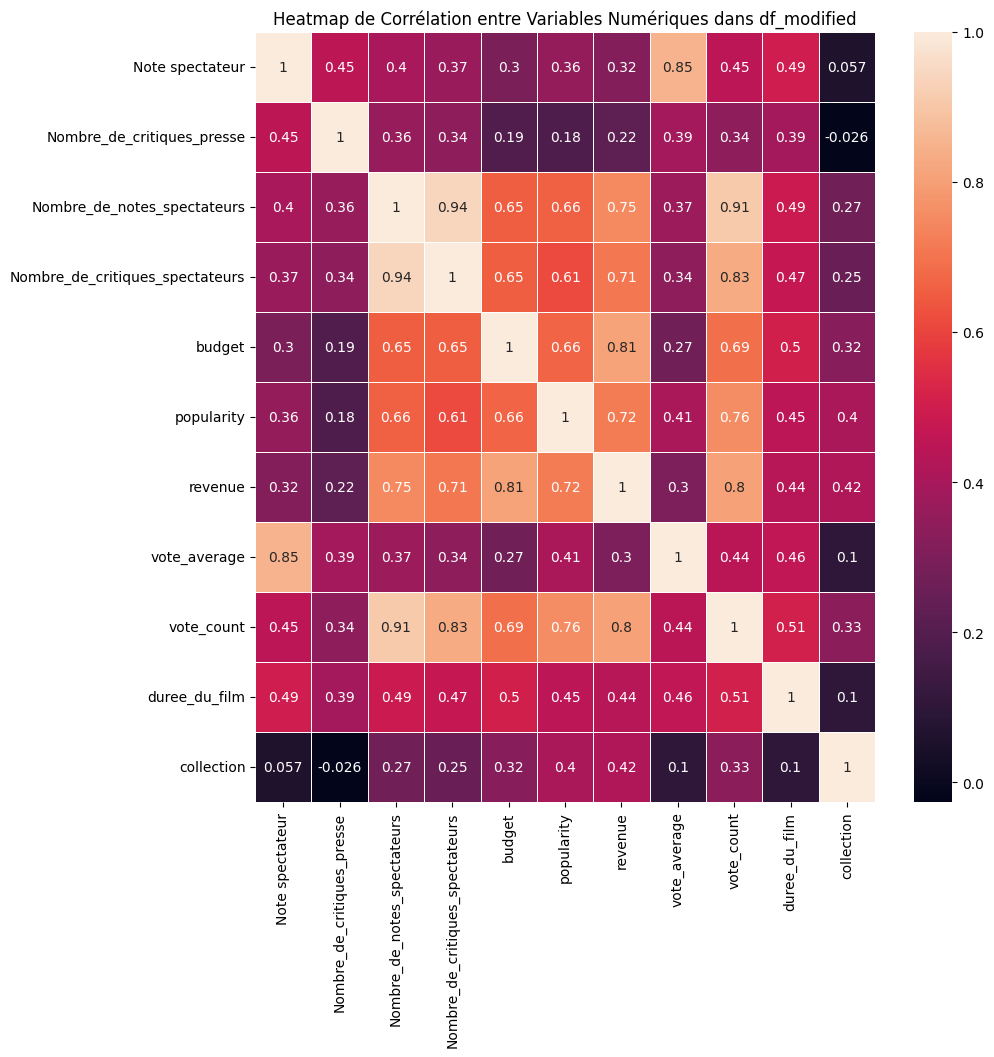

In [108]:
# Sélectionne uniquement les colonnes numériques non binaires
df_non_binary = df_modified[columns_to_include]

# Calcule la matrice de corrélation
correlation_matrix = df_non_binary.corr()

# Crée une heatmap avec seaborn
f, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
sns.heatmap(correlation_matrix, annot=True, linewidths=.5)

plt.title('Heatmap de Corrélation entre Variables Numériques dans df_modified')
plt.show()

En faisant cette analyse naive, on voit que le nombre de critiques spectateurs est fortement correlé au budget, revenue et a la popularité du film (soit les éléments qui déterminent le succès d'un film en général) avec des coefficients qui sont **supérieurs à 0.6**.  Donc cela, nous donne une information sur l'importance des critiques dans le succès d'un film mais n'établit pas forcément une relation causale solide. 

Regardons également la répartition de nos films en terme de genre. On observe que notre base est assez bien équilibré. Même si le genre **Drama** est en tête, on voit que les autres genres ont à peu près la même part. Cela est intéréssant car ça nous permet de ne pas avoir de biais de sélection au niveau du genre dans notre étude.

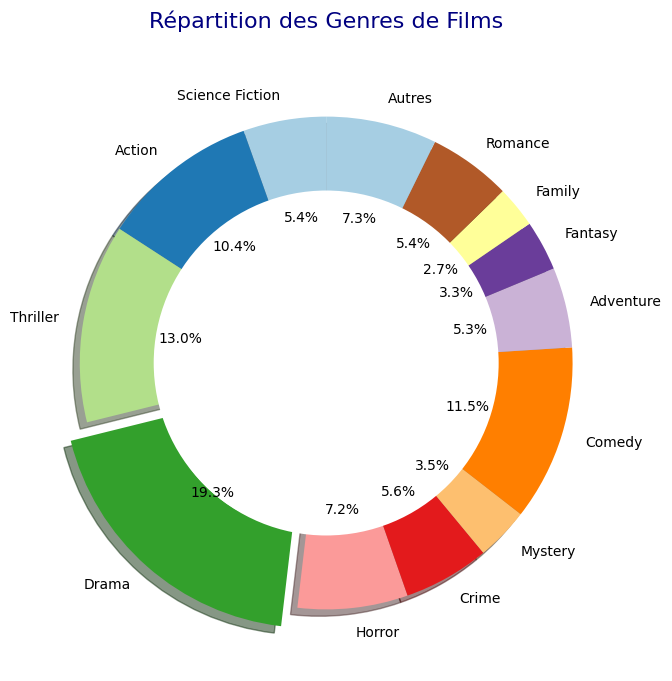

In [109]:
genres_columns = ['Science Fiction', 'Action', 'Thriller', 'Drama', 'Horror',
                   'Crime', 'Mystery', 'Comedy', 'Adventure', 'History', 'War',
                   'Fantasy', 'Family', 'Romance', 'TV Movie', 'Western',
                   'Music', 'Animation', 'Documentary']

# Somme des genres par colonne
genres_counts = df_modified[genres_columns].sum()

# Trouve le genre avec la plus grande part
max_genre = genres_counts.idxmax()

# Regrouper les genres moins fréquents sous "Autres" si nécessaire
seuil = 0.1  
genres_counts['Autres'] = genres_counts[genres_counts < seuil * genres_counts.max()].sum()
genres_counts = genres_counts[genres_counts >= seuil * genres_counts.max()]

# Ajoute une entrée pour le genre principal (avec effet de relief)
explode = [0.1 if genre == max_genre else 0 for genre in genres_counts.index]


plt.figure(figsize=(8, 8))
plt.pie(genres_counts, labels=genres_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, explode=explode,wedgeprops=dict(width=0.4),
        shadow=True)

plt.gca().add_artist(plt.Circle((0, 0), 0.70, fc='white'))

# Titre et personnalisation
plt.title('Répartition des Genres de Films', pad=20, fontsize=16, color='navy')

plt.show()

## b) Critiques : effet général

Nous commençons par voir l'effet temporel sur les critiques et les films. Cette information est importante pour voir comment évoluent nos données dans le temps et capter les éventuelles tendances.

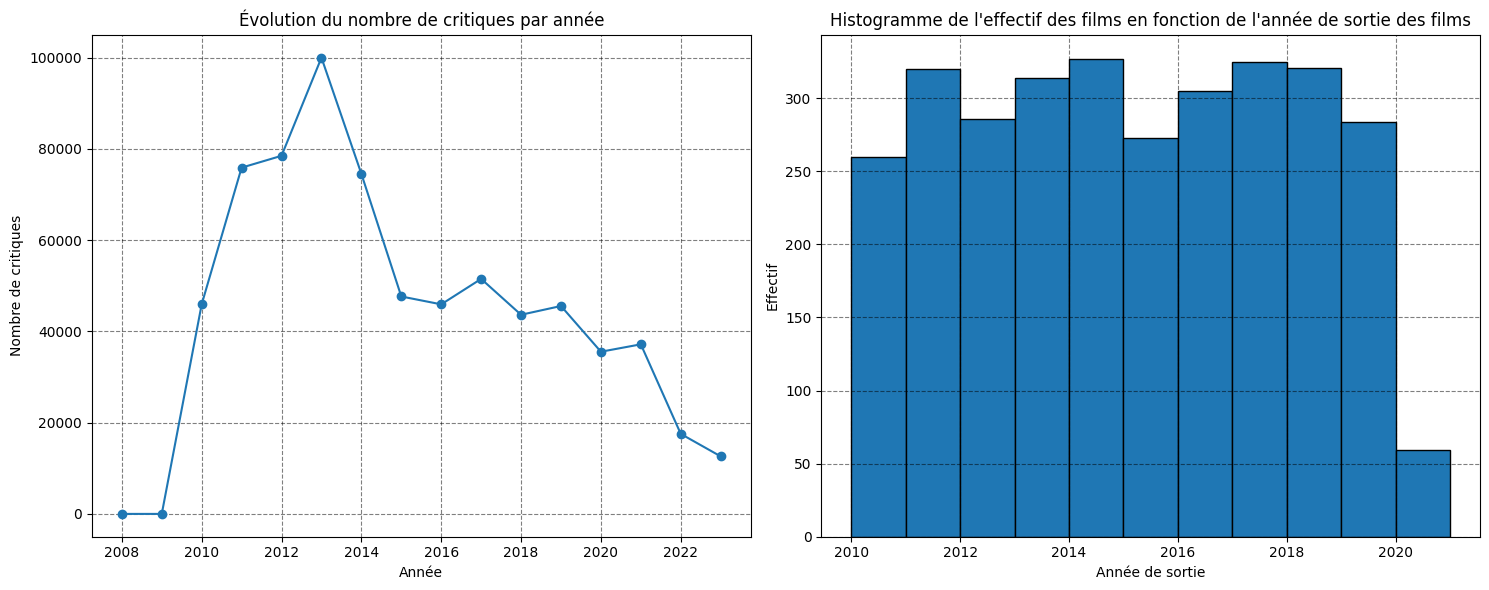

In [110]:
# Extraction l'année à partir de la colonne 'new_date'
df_critiques_modif['Année'] = df_critiques_modif['new_date'].dt.year

# Groupe par année et compte le nombre de critiques
evolution_critiques = df_critiques_modif.groupby('Année').size()

# Créer un graphique linéaire
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# évolution du nombre de critiques par année
axes[0].plot(evolution_critiques.index, evolution_critiques.values, marker='o', linestyle='-')
axes[0].grid(linestyle="dashed", alpha=0.5, color="black")
axes[0].set_title('Évolution du nombre de critiques par année')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Nombre de critiques')
axes[0].grid(True)

# histogramme de l'année de sortie des films
axes[1].hist(df_modified['annee_sortie'], bins=range(df_modified['annee_sortie'].min(), df_modified['annee_sortie'].max() + 1), edgecolor='black')
axes[1].grid(linestyle="dashed", alpha=0.5, color="black")
axes[1].set_xlabel('Année de sortie')
axes[1].set_ylabel('Effectif')
axes[1].set_title('Histogramme de l\'effectif des films en fonction de l\'année de sortie des films')

# Ajuste l'espacement entre les deux graphiques
plt.tight_layout()

# Affiche les graphiques
plt.show()


On observe que la tendance des critiques n'est pas la même que la tendance des films. L'évolution des films est plus homogène dans le temps alors que celle des critiques a connu son pic dans les années 2012-2014 et connait une baisse générale depuis. Cela nous montre deux informations principales. Concernant notre étude, il est possible que l'information pertinente pour la modélisation est comprise dans cette période. Ensuite, étant donnée l'opposition entre les deux tendances, on peut sûrement penser que les critiques n'ont plus trop d'importance et que la population n'y accorde plus trop d'importance avec l'émergence des réseaux sociaux. En effet, il est peut-être plus simple de déposer son avis sur ce type de plateforme et les critiques cinéma n'ont peut-être plus leur importance sur le boxoffice. On voit typiquement, deux arguments opposés et ce sera intéressant de tester cela grâce à la modélisation.

On voit dans le graphique suivant que même si la part de commentaires positifs est plus élévée, la différence avec la part de commentaires négatifs n'est pas trop grande. Donc notre base est bien répartie. Cela est important pour l'entraînement des modèles pour éviter de faire du **surapprentissage** lors de la prédiction du sentiment.

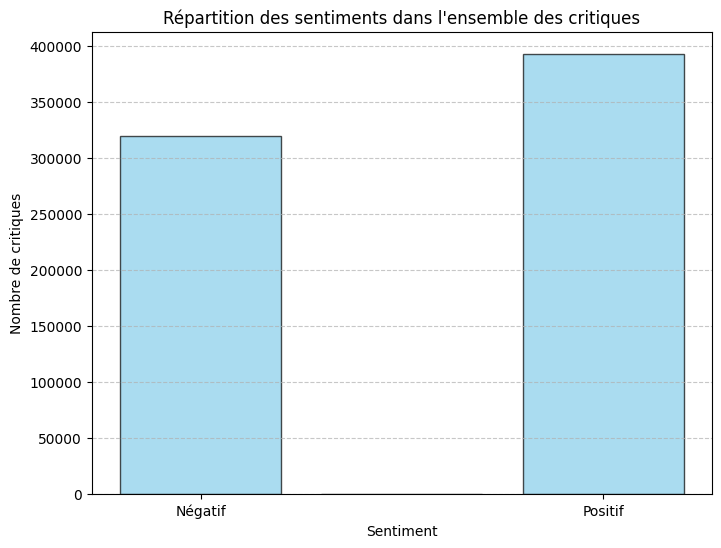

In [111]:
# Créer un histogramme des sentiments 
plt.figure(figsize=(8, 6))
plt.hist(df_critiques_modif['Polarité_réelle'], bins=[-0.25, 0.25, 0.75, 1.25], edgecolor='black', color='skyblue', alpha=0.7, align='mid', rwidth=0.8)
plt.xticks([0, 1], ['Négatif', 'Positif'])
plt.title('Répartition des sentiments dans l\'ensemble des critiques')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de critiques')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

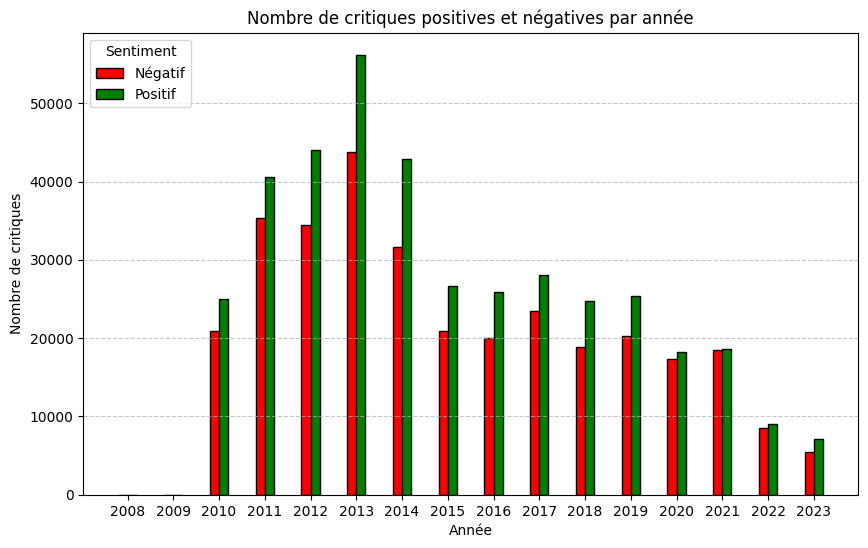

In [112]:
# Créer un DataFrame pivot pour obtenir le nombre de critiques par année et par sentiment
pivot_df = df_critiques_modif.pivot_table(index='Année', columns='Polarité_réelle', aggfunc='size', fill_value=0)

pivot_df.columns = ['Negatif', 'Positif']

# Définir la largeur des barres et l'espacement entre les groupes
bar_width = 0.2 # Ajustez selon vos préférences
bar_space = 0.2  # Ajustez selon vos préférences

# Créer un graphique en barres groupées avec l'espacement
plt.figure(figsize=(10, 6))
bar_positions_negatif = pivot_df.index - bar_space / 2
bar_positions_positif = pivot_df.index + bar_space / 2

plt.bar(bar_positions_negatif, pivot_df['Negatif'], width=bar_width, edgecolor='black', color='red', label='Négatif')
plt.bar(bar_positions_positif, pivot_df['Positif'], width=bar_width, edgecolor='black', color='green', label='Positif')

plt.title('Nombre de critiques positives et négatives par année')
plt.xlabel('Année')
plt.ylabel('Nombre de critiques')
plt.xticks(pivot_df.index)
plt.legend(title='Sentiment', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


On remarque que cette tendance de part entre commentaires positifs/négatifs reste à peu près constante dans le temps (avec le nombre de positifs qui est toujours plus élévé). Etant donné que nos commentaires sont pris aléatoirement, cette tendance ne posera donc pas de soucis.

Le but des graphiques ci-dessous est d'observer si le genre a un impact sur le nombre de critiques.

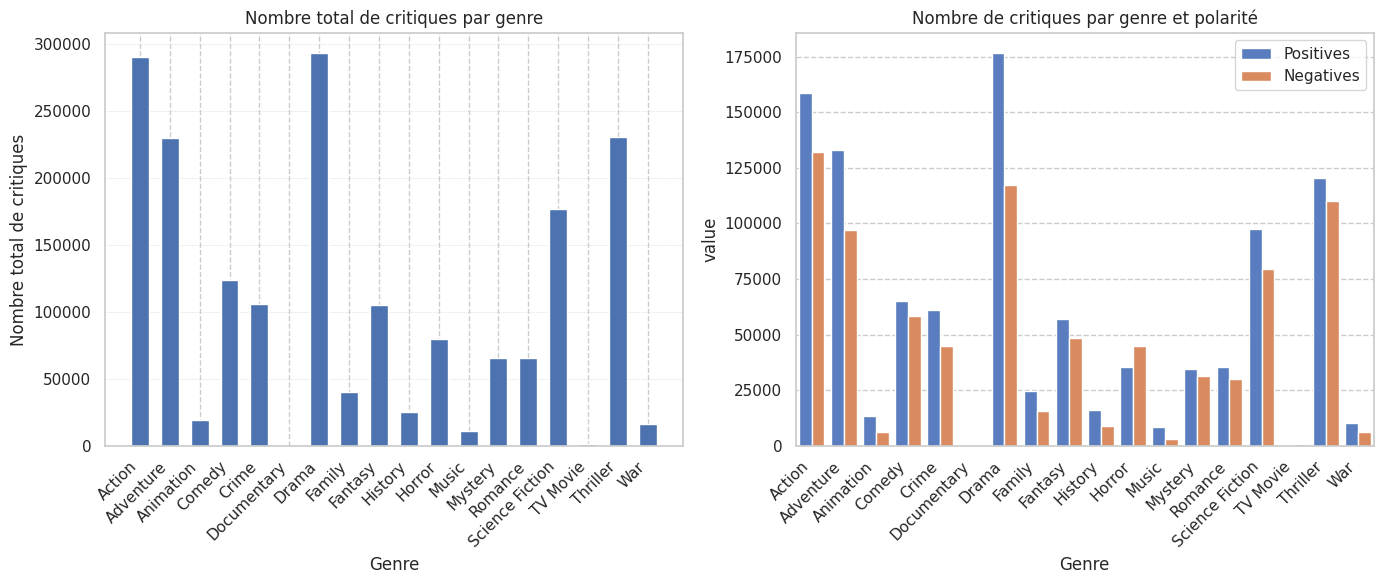

In [114]:
# Fusionne les deux DataFrames sur la colonne 'id_allocine'
merged_df = pd.merge(df_critiques_modif, df_modified, on='id_allocine')

# Calcule le nombre total de critiques par genre
genre_counts = merged_df.iloc[:, 26:44].groupby(merged_df['id_allocine']).sum()

# Somme les valeurs de chaque genre pour obtenir le total de critiques par genre
total_critiques_par_genre = genre_counts.sum()

# Crée un graphique à barres pour représenter le nombre total de critiques par genre
plt.figure(figsize=(14, 6))  
plt.subplot(1, 2, 1) 
plt.bar(total_critiques_par_genre.index, total_critiques_par_genre.values, width=0.6)
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour améliorer la lisibilité
plt.grid(axis='y', which='both', linestyle='dotted', linewidth=0.5)
plt.xlabel('Genre')
plt.ylabel('Nombre total de critiques')
plt.title('Nombre total de critiques par genre')

# Calcule le nombre total de critiques par genre
genre_counts = merged_df.iloc[:, 26:44].groupby(merged_df['id_allocine']).sum()

# Calcule le nombre de critiques positives et négatives par genre
positives_par_genre = merged_df[merged_df['Polarité_réelle'] == 1].iloc[:, 26:44].sum()
negatives_par_genre = merged_df[merged_df['Polarité_réelle'] == 0].iloc[:, 26:44].sum()

# Crée un DataFrame pour les données
data = pd.DataFrame({
    'Genre': genre_counts.columns,
    'Positives': positives_par_genre.values,
    'Negatives': negatives_par_genre.values
})

# Utilise Seaborn pour créer un graphique à barres groupé
plt.subplot(1, 2, 2) 
sns.set(style="whitegrid", rc={"grid.linestyle": "--"})
plot = sns.barplot(x='Genre', y='value', hue='variable', data=pd.melt(data, id_vars='Genre'), palette="muted")
plt.xticks(rotation=45, ha='right')

# Décale la légende de l'axe des x
plot.legend(loc='upper right')

plt.title('Nombre de critiques par genre et polarité')

plt.tight_layout()

plt.show()

A première observation, on voit que le genre impact le nombre de critiques et peut-être le sentiment des critiques. On voit que par exemple dans les genres **Drama** ou **Aventure** le nombre de commentaires positifs est strictement plus élevé que le nombre de commentaires négatifs. On essaie de voir avec un test d'indépendance de chi-2, s'il y a vraiment un lien entre le genre et le sentiment. Ce test dont l'hypothèse nulle est l'indépendance des variables est pratique pour vérifier les relations entre variables.

In [115]:
# Sélectionne les colonnes de genre
genre_columns = df_modified.columns[18:36]  

# Crée un tableau de contingence pour chaque variable binaire de genre
p_values = {}
for genre_column in genre_columns:
    contingency_table = pd.crosstab(merged_df['Polarité_réelle'], merged_df[genre_column])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    p_values[genre_column] = p

# Affiche les résultats
for genre, p_value in p_values.items():
    print(f"P-value for {genre}: {p_value}")


P-value for Action: 7.227480480536895e-54
P-value for Adventure: 1.1298726349197442e-159
P-value for Animation: 6.116207604265682e-292
P-value for Comedy: 7.949361172068662e-115
P-value for Crime: 1.036211310236227e-42
P-value for Documentary: 0.07687149537333683
P-value for Drama: 0.0
P-value for Family: 2.4243477284520053e-126
P-value for Fantasy: 4.532523293600538e-28
P-value for History: 4.721522066242705e-192
P-value for Horror: 0.0
P-value for Music: 1.2284006883810568e-303
P-value for Mystery: 2.9517957946802773e-75
P-value for Romance: 4.9045001261049124e-15
P-value for Science Fiction: 1.4458643176498612e-05
P-value for TV Movie: 3.150914780548878e-48
P-value for Thriller: 0.0
P-value for War: 3.044515217582651e-84


On voit que toutes les *p_value* sont **inférieurs à 0.05** donc on rejette l'hypothèse nulle d'indépendance, ce qui suggérerait qu'il existe un certain lien entre ces deux variables. Mais étant donné notre problématique, on décide de ne pas prendre en compte cet élément dans la suite de l'étude. On aurait également pu faire une régression logistique pour voir les effets plus en details.

Enfin, nous terminons cette partie en effectuant des WordCloud qui sont des graphiques primordiales dans l'étude des sentiments dans le sens où c'est une première vision des mots qui reviennent le plus souvent dans chaque type de sentiment.

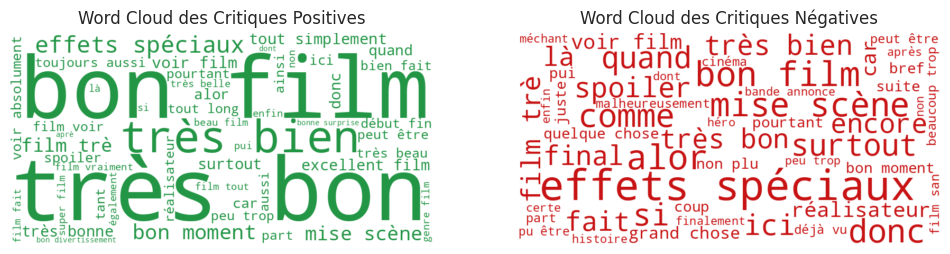

In [118]:
#ce code prend 3 à 4 minutes à être executé 

# Filtre les critiques positives et négatives
positive_reviews = df_critiques_modif[df_critiques_modif['Polarité_réelle'] == 1]['Critique_nettoye'].values
negative_reviews = df_critiques_modif[df_critiques_modif['Polarité_réelle'] == 0]['Critique_nettoye'].values

def darken_color(color, factor=0.8):  #pour assombrir les mots 
    return tuple(int(c * factor) for c in color)


# Création du Word Cloud pour les critiques positives
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='Greens').generate(' '.join(positive_reviews))
# Assombrit la couleur dans le Word Cloud positif
wordcloud_positive_color = wordcloud_positive.recolor(color_func=lambda *args, **kwargs: darken_color((70, 300, 140), factor=0.5))

# Création du Word Cloud pour les critiques négatives
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='Reds').generate(' '.join(negative_reviews))
# Assombrit la couleur dans le Word Cloud négatif
wordcloud_negative_color = wordcloud_negative.recolor(color_func=lambda *args, **kwargs: darken_color((400, 39, 40), factor=0.5))

# Affichage des Word Clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud des Critiques Positives')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud des Critiques Négatives')
plt.axis('off')

plt.show()


On voit déjà que des mots comme **"bien**, **"très bon"** reviennent dans les sentiments positifs et les mots comme **"malheureusement"**, **"effets speciaux"** reviennent dans les sentiments négatifs. Cela suggère qu'il est possible de voir une certaine distinction évidente entre les commentaires. Le problème, comme nous pouvons le voir, est que certains mots apparaissent dans les deux types de critiques. En effet, dans le cadre spécifique des films, certaines choses qui sont aimées par certains spectateurs (comme le **réalisateur**) peuvent ne pas être aimées par d'autres spectateurs. Donc cela nous donne déjà une piste sur le fait de diversifier nos données sur l'entraînement de nos modèles.

## c) Analyse au niveau individuel par film 

Cette partie de l'analyse va s'intéresser au film en cas par cas. Donc pour chaque graphique l'idée sera de visualiser le comportement pour un film spécifique tiré aléatoirement.

In [119]:
#On récupère la liste des id 
id_unique = df_critiques_modif["id_allocine"].unique().tolist()
len(id_unique)

3526

Dans un premier temps, on essaie de regarder les mots qui reviennent dans les critiques positives (et négatives) de chaque film. En effet, à chaque exécution, le code ci-dessous, renvoie les wordcloud associés aux films choisis aléatoirement.

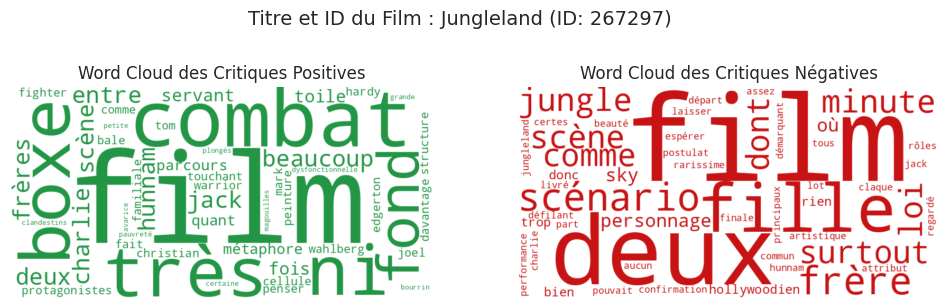

In [120]:
# Sélection aléatoire d'un identifiant avec au moins une critique positive et une critique négative
id_aleatoire = None
while id_aleatoire is None or len(df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 1)]) == 0 or len(df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 0)]) == 0:
    id_aleatoire = random.choice(id_unique)


# Filtre les critiques pour l'identifiant sélectionné
critiques_positives = df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 1)]['Critique_nettoye'].values
critiques_negatives = df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire) & (df_critiques_modif['Polarité_réelle'] == 0)]['Critique_nettoye'].values

# Création du Word Cloud pour les critiques positives
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='Greens').generate(' '.join(critiques_positives))

# Assombrit la couleur dans le Word Cloud positif
wordcloud_positive_color = wordcloud_positive.recolor(color_func=lambda *args, **kwargs: darken_color((70, 300, 140), factor=0.5))


# Création du Word Cloud pour les critiques négatives
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', max_words=50, colormap='Reds').generate(' '.join(critiques_negatives))
# Assombrit la couleur dans le Word Cloud négatif
wordcloud_negative_color = wordcloud_negative.recolor(color_func=lambda *args, **kwargs: darken_color((400, 39, 40), factor=0.5))

# Affichage des Word Clouds
plt.figure(figsize=(12, 6))

# Affichage du Word Cloud pour les critiques positives
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud des Critiques Positives')
plt.axis('off')

# Affichage du Word Cloud pour les critiques négatives
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud des Critiques Négatives')
plt.axis('off')

# Titre général en dessous des deux graphiques
plt.suptitle(f'Titre et ID du Film : {df_modified[df_modified["id_allocine"] == id_aleatoire]["Titre original"].values[0]} (ID: {id_aleatoire})', y=0.8, size=14)

plt.show()



On observe très clairement que des mots reviennent très souvent comme ***"Très bien"***, ***"Mauvais"***... qui sont des mots spécifiques à la positivité ou la négativité du commentaire (comme dans le cas général). Mais étant à une échelle plus petite, on voit que les mots spécifiques au film reviennent dans les cloud. Cela est intéréssent puisque, on obtient l'information de ce qui est aimé par le public et ce qui détermine si le film sera un hit ou non. Ces mots propres aux films peuvent donc être un déterminant de ce qui peut changer la trajectoire du boxoffice.

Pour finir, pour avoir un pas sur le lien entre boxoffice et types de critiques d'un film, on trace l'évolution du nombre de critiques totales, positives et négatives. D'autre part, on créer pour chaque film une metrique qui mesure le succès potentiel d'un film en se basant sur son budget et ses recettes. La métrique est la suivante : $$\frac{budget-recette}{budget}$$.

/tmp/ipykernel_100270/2709746767.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_film_selectionne['mois_annee'] = pd.to_datetime(df_film_selectionne['new_date']).dt.to_period('M')


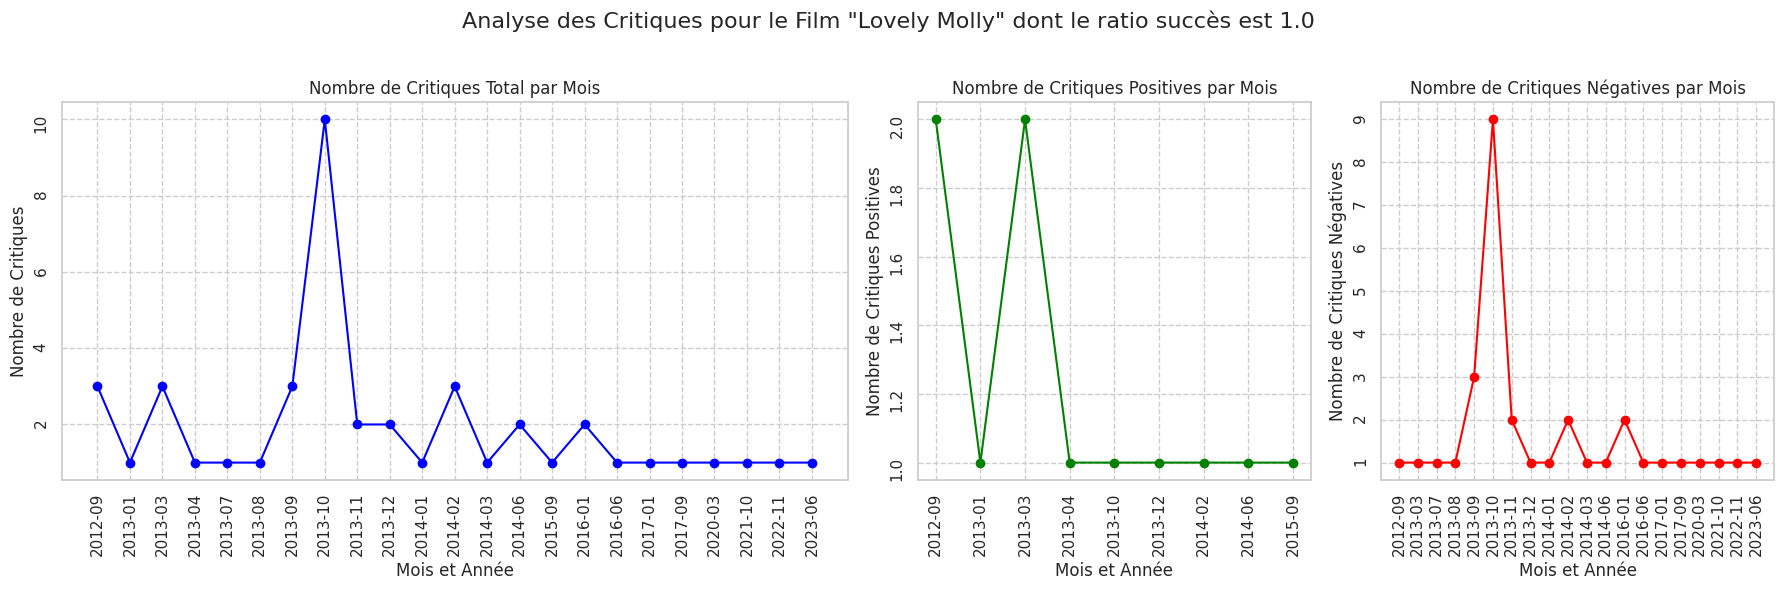

In [123]:
# Sélection aléatoire d'un film
id_aleatoire = None
while id_aleatoire is None or len(df_critiques_modif[(df_critiques_modif['id_allocine'] == id_aleatoire)]) == 0:
    id_aleatoire = random.choice(df_critiques_modif['id_allocine'].unique())

# Filtre les critiques pour l'identifiant sélectionné
titre_original = df_modified[df_modified['id_allocine'] == id_aleatoire]['Titre original'].values[0]
df_film_selectionne = df_critiques_modif[df_critiques_modif['id_allocine'] == id_aleatoire]

# Crée une nouvelle colonne 'mois_annee' pour l'échelle de temps en mois
df_film_selectionne['mois_annee'] = pd.to_datetime(df_film_selectionne['new_date']).dt.to_period('M')

# Trie le DataFrame par date
df_film_selectionne = df_film_selectionne.sort_values(by='new_date')

# Crée une figure avec une ligne et trois colonnes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1, 1]})

# Trace le nombre de critiques totales par mois
df_total_per_month = df_film_selectionne.groupby('mois_annee').size()
axes[0].plot(df_total_per_month.index.astype(str), df_total_per_month.values, marker='o', linestyle='-', color='blue')
axes[0].set_title(f'Nombre de Critiques Total par Mois')
axes[0].set_xlabel('Mois et Année')
axes[0].set_ylabel('Nombre de Critiques')
axes[0].tick_params(rotation=90)

# Filtre les critiques positives et négatives
df_positives = df_film_selectionne[df_film_selectionne['Polarité_réelle'] == 1]
df_negatives = df_film_selectionne[df_film_selectionne['Polarité_réelle'] == 0]

# Trace le nombre de critiques positives par mois
df_positives_per_month = df_positives.groupby('mois_annee').size()
axes[1].plot(df_positives_per_month.index.astype(str), df_positives_per_month.values, marker='o', linestyle='-', color='green')
axes[1].set_title(f'Nombre de Critiques Positives par Mois')
axes[1].set_xlabel('Mois et Année')
axes[1].set_ylabel('Nombre de Critiques Positives')
axes[1].tick_params(rotation=90)

# Trace le nombre de critiques négatives par mois
df_negatives_per_month = df_negatives.groupby('mois_annee').size()
axes[2].plot(df_negatives_per_month.index.astype(str), df_negatives_per_month.values, marker='o', linestyle='-', color='red')
axes[2].set_title(f'Nombre de Critiques Négatives par Mois')
axes[2].set_xlabel('Mois et Année')
axes[2].set_ylabel('Nombre de Critiques Négatives')
axes[2].tick_params(rotation=90)

a=(df_modified.loc[df_modified['id_allocine'] == id_aleatoire,'budget'].values[0]-df_modified.loc[df_modified['id_allocine'] == id_aleatoire,'revenue'].values[0])/df_modified.loc[df_modified['id_allocine'] == id_aleatoire,'budget'].values[0]
# Ajoute un titre général
fig.suptitle(f'Analyse des Critiques pour le Film "{titre_original}" dont le ratio succès est {a} ', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste la zone de sous-titre
plt.show()



Le but de ce graphique est de voir s'il y a un lien entre l'évolution du nombre de critiques (selon son type) et notre metrique. Pour simplifier, on suppose que si notre métrique est positive le film est un flop, si elle est négative le film est un hit. On voit qu'en répétant le graphique sur plusieurs films, lorsque le nombre de critiques positives est plus élévée ou augmente, notre score a tendance a être négatif (et inversement pour le cas des critiques négatives).
Dans l'exemple ci-dessus, pour le film *Lovely Molly*, on voit que le nombre de critiques négatifs étaient plus élevé et que son augmentation était très importante et que le score est négatif. 
Cela suggère un premier lien que nous devrons vérifier dans la partie suivante qui repose sur la modélisation.

Pour des raisons de lisibilité et de clarté, la partie modélisation et la conclusion de notre étude est dans un fichier à part que vous trouverez dans le lien suivant : https://github.com/mass2330/python_ds_film/blob/main/modelisation.ipynb